## Multiple Linear Model

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.model_selection as ms
from sklearn.metrics import explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import aic
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [2]:
data = pd.read_csv('./data/all_data_CLEAN.csv', index_col=0)

In [3]:
# Change ints to str for ordinal features
data["MSSubClass"] = data["MSSubClass"].astype("str")

In [4]:
ames_housing_X = data.iloc[:,3:80]
y = data["SalePricePerGLA"]

In [5]:
num_colnames = ['LotFrontage', 'LotArea',
    'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
    'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 
    'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 
    'KitchenAbvGr','TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 
    'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
    'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

ord_colnames = ['LotShape', 'LandSlope', 'OverallQual', 'OverallCond', 
                'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
                'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 
                'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 
                'GarageQual', 'GarageCond', 'PoolQC', 'Fence']

cat_colnames = [feature_ for feature_ in list(ames_housing_X.columns) 
                if feature_ not in num_colnames and feature_ not in ord_colnames]


In [6]:
# Manual Label Encoding of Ordinal Features
for i in range(len(ord_colnames)):
    print(f'{i} : {ord_colnames[i]} : {ames_housing_X[ord_colnames[i]].unique()}')

0 : LotShape : ['Reg' 'IR1' 'IR3' 'IR2']
1 : LandSlope : ['Gtl' 'Mod' 'Sev']
2 : OverallQual : [ 6  5  4  8  7  3 10  9  2  1]
3 : OverallCond : [6 5 9 8 4 3 7 2 1]
4 : ExterQual : ['TA' 'Gd' 'Fa' 'Ex']
5 : ExterCond : ['TA' 'Gd' 'Fa' 'Ex' 'Po']
6 : BsmtQual : ['TA' 'Gd' 'Fa' 'NoneListed' 'Ex' 'Po']
7 : BsmtCond : ['TA' 'NoneListed' 'Fa' 'Gd' 'Ex' 'Po']
8 : BsmtExposure : ['No' 'Mn' 'NoneListed' 'Gd' 'Av']
9 : BsmtFinType1 : ['Rec' 'GLQ' 'ALQ' 'Unf' 'NoneListed' 'BLQ' 'LwQ']
10 : BsmtFinType2 : ['Unf' 'ALQ' 'NoneListed' 'GLQ' 'BLQ' 'LwQ' 'Rec']
11 : HeatingQC : ['TA' 'Ex' 'Gd' 'Fa' 'Po']
12 : KitchenQual : ['TA' 'Gd' 'Ex' 'Fa' 'Po']
13 : Functional : ['Typ' 'Min2' 'Min1' 'Mod' 'Maj1' 'Maj2']
14 : FireplaceQu : ['Gd' 'NoneListed' 'Ex' 'TA' 'Fa' 'Po']
15 : GarageFinish : ['Unf' 'Fin' 'RFn' 'NoneListed']
16 : GarageQual : ['TA' 'NoneListed' 'Fa' 'Gd' 'Po' 'Ex']
17 : GarageCond : ['TA' 'Po' 'NoneListed' 'Fa' 'Gd' 'Ex']
18 : PoolQC : ['NoneListed' 'Ex' 'Gd' 'TA' 'Fa']
19 : Fence : ['NoneLis

In [7]:
ord_colnames = ['LotShape', 'LandSlope', 'OverallQual', 'OverallCond', 
                'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
                'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 
                'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 
                'GarageQual', 'GarageCond', 'PoolQC', 'Fence']

ord_dict = {}
ord_dict['LotShape'] = ['IR3', 'IR2', 'IR1', 'Reg']
ord_dict['LandSlope'] = ['Sev', 'Mod', 'Gtl']
ord_dict['OverallQual'] = [np.nan, 1,2,3,4,5,6,7,8,9,10]
ord_dict['OverallCond'] = [np.nan, 1,2,3,4,5,6,7,8,9,10]
ord_dict['ExterQual'] = [np.nan, 'Po', 'Fa','TA', 'Gd', 'Ex']
ord_dict['ExterCond'] = [np.nan, 'Po', 'Fa','TA', 'Gd', 'Ex']
ord_dict['BsmtQual'] = ['NoneListed', 'Po', 'Fa','TA', 'Gd', 'Ex']
ord_dict['BsmtCond'] = ['NoneListed', 'Po', 'Fa','TA', 'Gd', 'Ex']
ord_dict['BsmtExposure'] = ['NoneListed', 'No', 'Mn', 'Av', 'Gd']
ord_dict['BsmtFinType1'] = ['NoneListed', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
ord_dict['BsmtFinType2'] = ['NoneListed', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
ord_dict['HeatingQC'] = [np.nan, 'Po', 'Fa','TA', 'Gd', 'Ex']
ord_dict['KitchenQual'] = [np.nan, 'Po', 'Fa','TA', 'Gd', 'Ex']
ord_dict['Functional'] = ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']
ord_dict['FireplaceQu'] = ['NoneListed', 'Po', 'Fa','TA', 'Gd', 'Ex']
ord_dict['GarageFinish'] = ['NoneListed', 'Unf', 'RFn', 'Fin']
ord_dict['GarageQual'] = ['NoneListed', 'Po', 'Fa','TA', 'Gd', 'Ex']
ord_dict['GarageCond'] = ['NoneListed', 'Po', 'Fa','TA', 'Gd', 'Ex']
ord_dict['PoolQC'] = ['NoneListed', 'Po', 'Fa','TA', 'Gd', 'Ex']
ord_dict['Fence'] = ['NoneListed', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']

# Trasforms Labels to Numbers
for i in range(len(ord_colnames)):
    ames_housing_X[ord_colnames[i]] = ames_housing_X[ord_colnames[i]].apply(lambda x: ord_dict[ord_colnames[i]].index(x))

# Trasforms Numbers back to Labels
# for i in range(len(ord_colnames)):
#     ames_housing_X[ord_colnames[i]] = ames_housing_X[ord_colnames[i]].apply(lambda x: ord_dict[ord_colnames[i]][x])

In [8]:
# Master X Features Dataframe for Linear Regression
cat_dummies = pd.get_dummies(ames_housing_X[cat_colnames],drop_first=True)
X = pd.concat((ames_housing_X[ord_colnames], ames_housing_X[num_colnames]), axis=1)
X = pd.concat((ames_housing_X[cat_colnames], X), axis=1)

In [9]:
for i in range(len(X.columns)):
    print(X.columns[i])

MSSubClass
MSZoning
Street
Alley
LandContour
LotConfig
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
Foundation
Heating
CentralAir
Electrical
GarageType
PavedDrive
MiscFeature
SaleType
SaleCondition
LotShape
LandSlope
OverallQual
OverallCond
ExterQual
ExterCond
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
HeatingQC
KitchenQual
Functional
FireplaceQu
GarageFinish
GarageQual
GarageCond
PoolQC
Fence
LotFrontage
LotArea
YearBuilt
YearRemodAdd
MasVnrArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
1stFlrSF
2ndFlrSF
LowQualFinSF
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
TotRmsAbvGrd
Fireplaces
GarageYrBlt
GarageCars
GarageArea
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
MiscVal
MoSold
YrSold


In [10]:
# Fliter out Bottom 80 by GLA
data_w_GLA = pd.concat((data[['GrLivArea', 'SalePricePerGLA']], X), axis=1).reset_index(drop=True)

top_twenty = list(data_w_GLA.nlargest((round(len(data_w_GLA)*.2)),'GrLivArea').index)
bottom_eighty = list(data_w_GLA.nsmallest((round(len(data_w_GLA)*.8)),'GrLivArea').index)

data_80 = data_w_GLA.iloc[bottom_eighty]
y_80 = data_80.iloc[:,1:2].reset_index(drop=True)
X_80 = data_80.iloc[:,2:].reset_index(drop=True)

### Check Assumptions

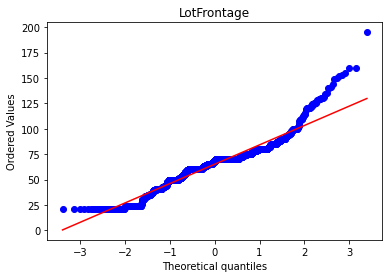

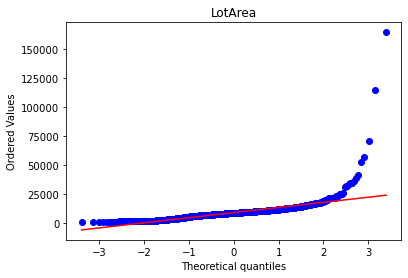

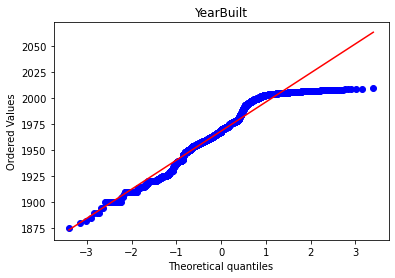

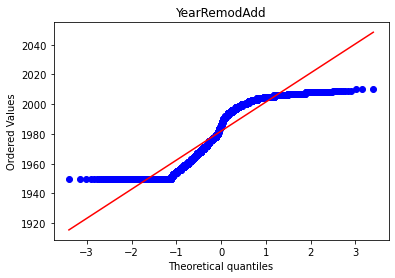

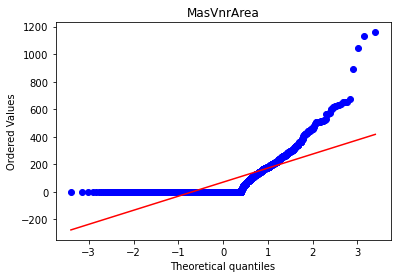

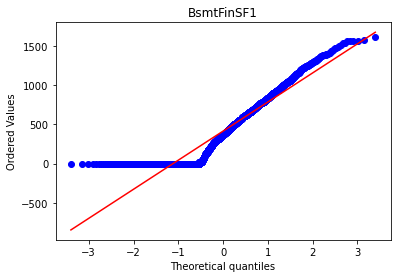

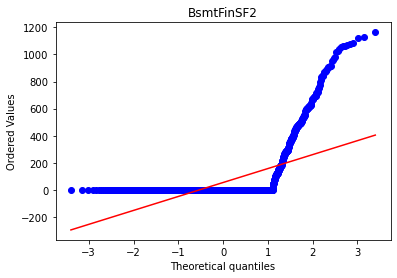

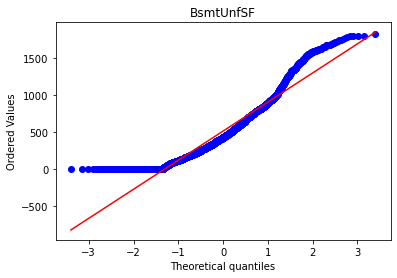

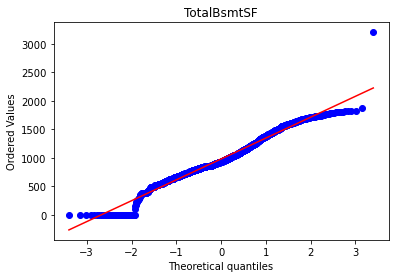

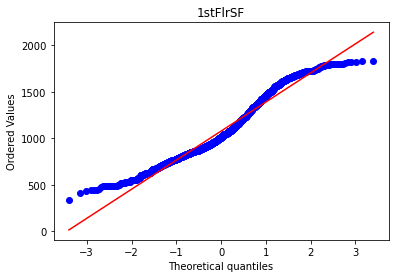

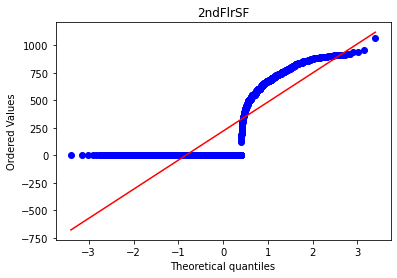

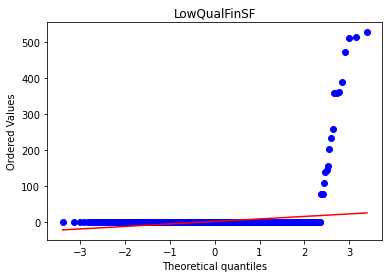

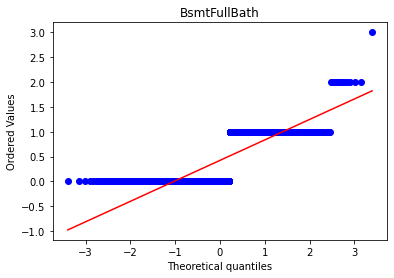

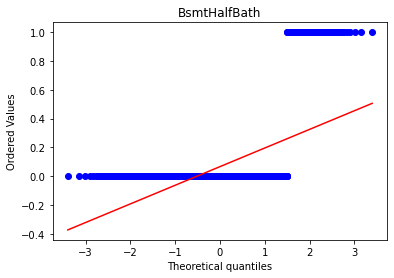

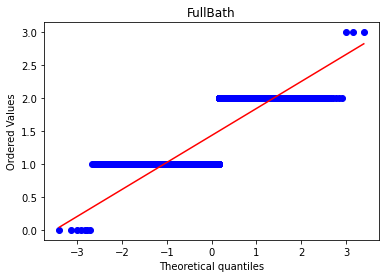

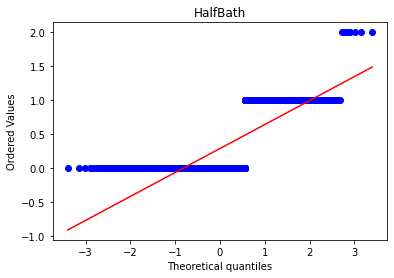

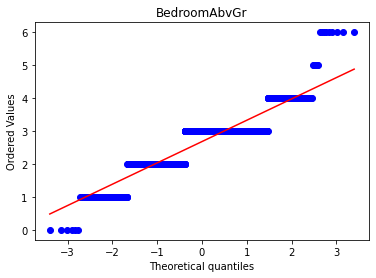

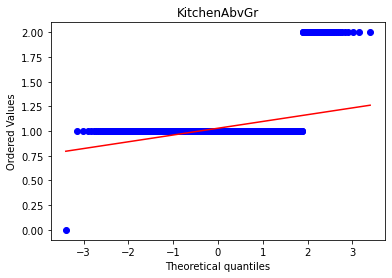

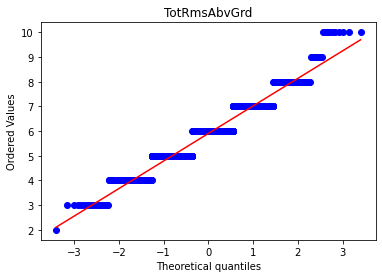

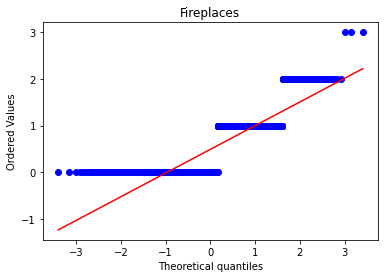

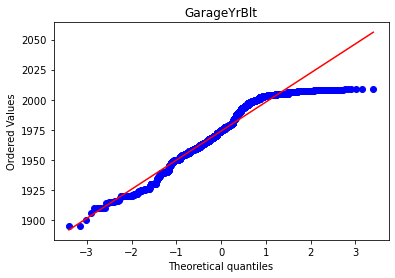

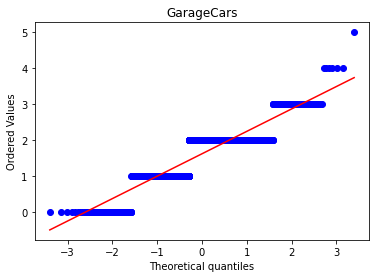

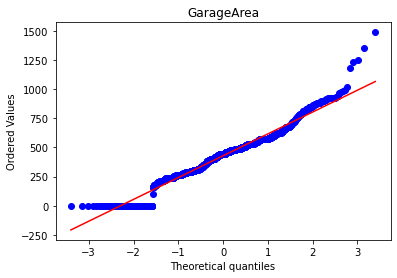

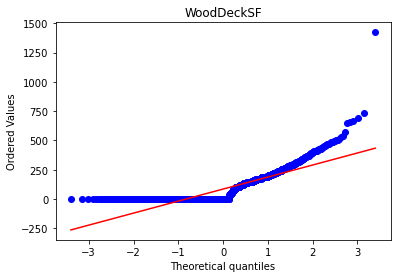

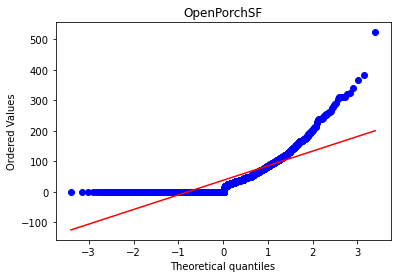

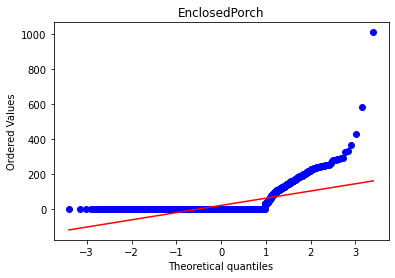

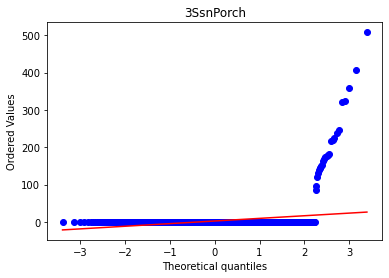

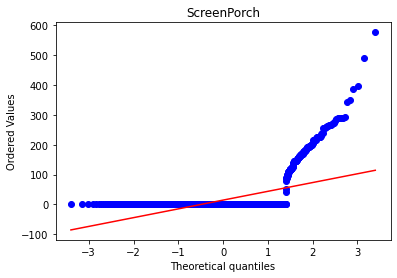

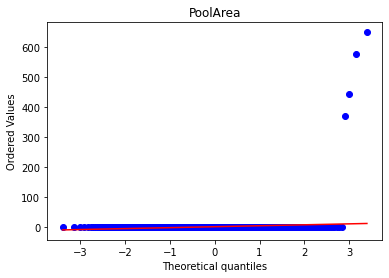

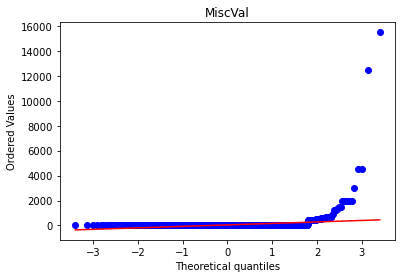

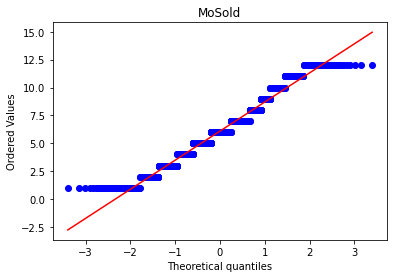

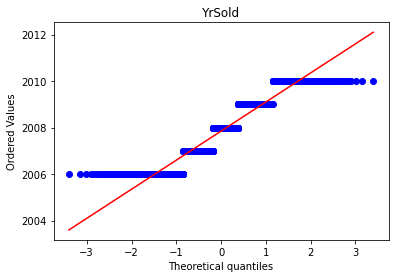

In [11]:
import scipy.stats as stats

for col_ in num_colnames:
    stats.probplot(X_80[col_], dist="norm", plot=plt)
    plt.title(col_)
    plt.show()


In [12]:
X_80[num_colnames].corr().style.background_gradient(cmap='coolwarm')


,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
LotFrontage,1.000000,0.402812,-0.004693,-0.044457,0.033382,0.100191,0.060986,0.092792,0.236530,0.343363,-0.177496,-0.032730,0.053530,0.005109,0.021451,-0.092052,0.247223,0.033537,0.246798,0.134252,-0.029757,0.166283,0.223657,0.065391,0.050008,0.051511,0.047498,0.085605,0.038319,0.031327,-0.019718,0.023095
LotArea,0.402812,1.000000,-0.006412,-0.027201,0.024388,0.164390,0.060610,-0.002083,0.198941,0.301521,-0.108904,-0.006310,0.119167,0.018002,0.050128,-0.038990,0.132102,0.007602,0.159228,0.215387,-0.015443,0.145658,0.193136,0.177892,0.042359,0.040235,0.027494,0.040924,0.026301,0.053370,0.007260,-0.010570
YearBuilt,-0.004693,-0.006412,1.000000,0.562800,0.266457,0.270765,-0.009468,0.114022,0.407574,0.332562,-0.068518,-0.077810,0.199877,-0.024792,0.508171,0.204663,-0.068368,-0.086130,0.066157,0.109327,0.843263,0.508365,0.445832,0.205927,0.209627,-0.363408,0.004429,-0.048108,0.007266,-0.016331,-0.003270,0.029003
YearRemodAdd,-0.044457,-0.027201,0.562800,1.000000,0.108925,0.105824,-0.040709,0.137083,0.244799,0.187661,0.095207,-0.048422,0.128759,-0.036352,0.436618,0.133722,-0.074668,-0.126470,0.123649,0.048939,0.602267,0.354672,0.298711,0.191442,0.223144,-0.196737,0.029449,-0.065616,-0.001551,-0.010324,-0.004360,0.079459
MasVnrArea,0.033382,0.024388,0.266457,0.108925,1.000000,0.188178,-0.007219,0.070102,0.272836,0.259091,-0.045452,-0.044038,0.089617,0.004370,0.182514,0.093563,0.027626,-0.032231,0.112710,0.168411,0.208647,0.243215,0.231279,0.084699,0.074321,-0.106046,0.019258,0.035155,-0.012853,-0.007278,-0.004968,-0.010422
BsmtFinSF1,0.100191,0.164390,0.270765,0.105824,0.188178,1.000000,-0.065635,-0.524997,0.442814,0.370124,-0.299130,-0.058236,0.612049,0.077617,0.036889,-0.101924,-0.099676,-0.101685,-0.084762,0.225196,0.189666,0.200963,0.247731,0.196408,0.086550,-0.107484,0.038769,0.115273,0.005782,0.030016,0.001967,0.015483
BsmtFinSF2,0.060986,0.060610,-0.009468,-0.040709,-0.007219,-0.065635,1.000000,-0.256005,0.106809,0.090633,-0.137138,-0.000020,0.171480,0.111749,-0.085244,-0.028823,-0.022886,-0.030411,-0.067339,0.035654,-0.023422,0.002324,0.030144,0.097534,-0.017477,0.016919,-0.027601,0.041326,0.033001,-0.010943,-0.007631,0.004785
BsmtUnfSF,0.092792,-0.002083,0.114022,0.137083,0.070102,-0.524997,-0.256005,1.000000,0.436661,0.315760,-0.041801,0.019976,-0.387432,-0.102684,0.285284,-0.072514,0.172017,0.110231,0.276961,0.004730,0.141093,0.158038,0.129100,-0.065107,0.106697,0.007306,0.002309,-0.056924,-0.008557,-0.025171,-0.004840,0.012975
TotalBsmtSF,0.236530,0.198941,0.407574,0.244799,0.272836,0.442814,0.106809,0.436661,1.000000,0.781928,-0.424862,-0.039297,0.295069,0.019455,0.315837,-0.201102,0.074956,0.000914,0.186538,0.259151,0.345620,0.388147,0.418198,0.179850,0.201480,-0.097492,0.030759,0.077504,0.011788,-0.001263,-0.006796,0.032907
1stFlrSF,0.343363,0.301521,0.332562,0.187661,0.259091,0.370124,0.090633,0.315760,0.781928,1.000000,-0.551794,-0.040072,0.240372,0.017131,0.329661,-0.279107,0.084558,0.118454,0.285790,0.336969,0.274657,0.395404,0.428681,0.172356,0.155219,-0.081638,0.044065,0.113513,0.026531,0.000407,0.017630,0.004026


In [13]:
# Correlations of Concern
# YearBuilt: GarageYrBlt (0.843263)
# TotalBsmtSF: 1stFlrSF (0.781928)
# GarageCars: GarageArea(0.882593)

import statsmodels.api as sm
X_add_const = sm.add_constant(X_80[num_colnames])
ols = sm.OLS(y_80, X_add_const).fit()
predictions = ols.predict(X_add_const)
df_results = pd.DataFrame({'Actual': y_80['SalePricePerGLA'], 'Predicted': predictions})
df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
df_results

,Actual,Predicted,Residuals
0,117.664671,112.364837,5.299833
1,114.250614,128.565080,-14.314466
2,136.986301,116.831720,20.154581
3,73.564583,130.002728,-56.438145
4,125.000000,123.566976,1.433024
...,...,...,...
2037,110.837438,88.689623,22.147815
2038,82.554158,77.482582,5.071575
2039,152.899344,150.571539,2.327804
2040,129.579005,119.201157,10.377848


In [14]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=7)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()

In [15]:
# Try Linear Regression Model with num variables
X_add_const = sm.add_constant(X_80[num_colnames])
ols = sm.OLS(y_80, X_add_const).fit()

In [16]:
print(ols.rsquared_adj)
pvals = ols.pvalues.sort_values(ascending=False)
type(pvals.index[0])
# pvals[0]
print(ols.aic)
ols.summary()
# Model is bad. Being affected by multicolinearity.

0.6789733519388699
17192.10800515848


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        SalePricePerGLA   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     140.2
Date:                Wed, 07 Jul 2021   Prob (F-statistic):               0.00
Time:                        00:14:00   Log-Likelihood:                -8564.1
No. Observations:                2042   AIC:                         1.719e+04
Df Residuals:                    2010   BIC:                         1.737e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -442.9089    558.195     -0.793      0.428   -1537.611     651.793
LotFrontage       0.1074      0.022      4.907      0.000       0.064       0.150
LotArea           0.0002   6.73e-05      3.170      0.002    8.13e-05       0.000
YearBuilt         0.2440      0.027      8.959      0.000       0.191       0.297
YearRemodAdd      0.3105      0.023     13.377      0.000       0.265       0.356
MasVnrArea        0.0047      0.003      1.566      0.118      -0.001       0.010
BsmtFinSF1        0.0125      0.001     11.924      0.000       0.010       0.015
BsmtFinSF2        0.0032      0.002      1.890      0.059      -0.000       0.006
BsmtUnfSF         0.0020      0.001      2.141      0.032       0.000       0.004
TotalBsmtSF       0.0176      0.001     12.805      0.000       0.015       0.020
1stFlrSF         -0.0447      0.003    -16.337      0.000      -0.050      -0.039
2ndFlrSF         -0.0418      0.003    -16.620      0.000      -0.047      -0.037
LowQualFinSF     -0.0610      0.012     -4.998      0.000      -0.085      -0.037
BsmtFullBath      2.8679      1.011      2.835      0.005       0.884       4.852
BsmtHalfBath      2.7934      1.553      1.798      0.072      -0.253       5.840
FullBath          0.5152      1.156      0.446      0.656      -1.752       2.782
HalfBath         -3.0572      1.120     -2.729      0.006      -5.254      -0.860
BedroomAbvGr     -5.4055      0.720     -7.504      0.000      -6.818      -3.993
KitchenAbvGr    -12.6405      2.390     -5.290      0.000     -17.327      -7.954
TotRmsAbvGrd      0.6538      0.557      1.173      0.241      -0.439       1.747
Fireplaces        4.6620      0.704      6.624      0.000       3.282       6.042
GarageYrBlt       0.0618      0.031      2.015      0.044       0.002       0.122
GarageCars        3.6486      1.207      3.022      0.003       1.281       6.016
GarageArea        0.0091      0.004      2.086      0.037       0.001       0.018
WoodDeckSF        0.0132      0.003      4.056      0.000       0.007       0.020
OpenPorchSF       0.0106      0.007      1.567      0.117      -0.003       0.024
EnclosedPorch     0.0124      0.006      1.974      0.048    8.33e-05       0.025
3SsnPorch         0.0079      0.014      0.562      0.574      -0.020       0.036
ScreenPorch       0.0173      0.007      2.480      0.013       0.004       0.031
PoolArea          0.0109      0.016      0.688      0.491      -0.020       0.042
MiscVal           0.0009      0.001      1.209      0.227      -0.001       0.002
MoSold            0.1633      0.138      1.184      0.237      -0.107       0.434
YrSold           -0.3093      0.278     -1.114      0.266      -0.854       0.235
==============================================================================
Omnibus:                      202.780   Durbin-Watso

C:\Users\Nixon\anaconda3\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


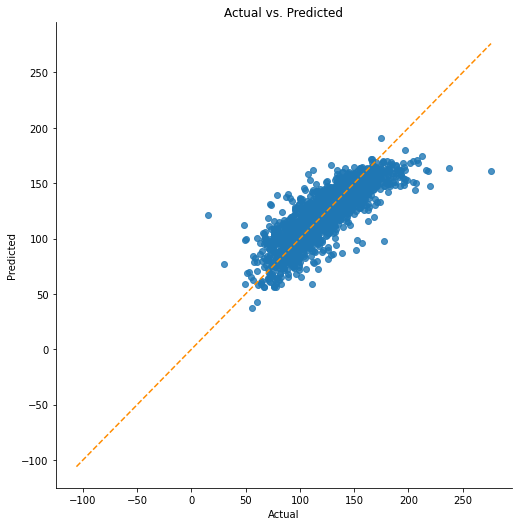

In [17]:
# Plot of Errors
# Calculating residuals for the plot
predictions = ols.predict(X_add_const)
df_results = pd.DataFrame({'Actual': y_80['SalePricePerGLA'], 'Predicted': predictions})
df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
df_results

# Plotting the actual vs predicted values
sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=7)

# Plotting the diagonal line
line_coords = np.arange(df_results.min().min(), df_results.max().max())
plt.plot(line_coords, line_coords,  # X and y points
         color='darkorange', linestyle='--')
plt.title('Actual vs. Predicted')
plt.show()

C:\Users\Nixon\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


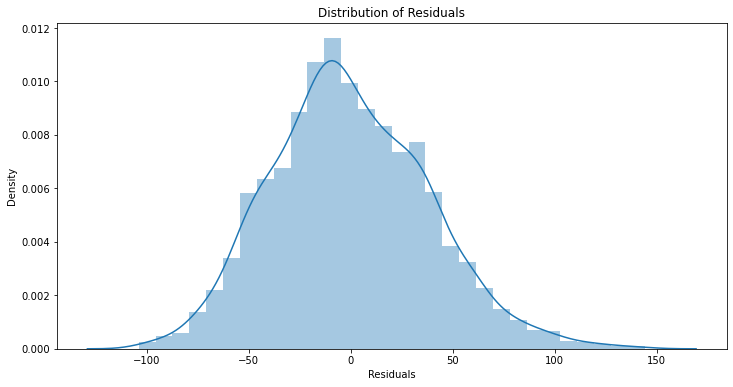

In [18]:
# Calculating residuals
df_results = calculate_residuals(ols, X_add_const, y)
# Plotting the residuals distribution
plt.subplots(figsize=(12, 6))
plt.title('Distribution of Residuals')
sns.distplot(df_results['Residuals'])
plt.show()

In [19]:
def multicollinearity_assumption(model, features, label, feature_names=None):
    """
    Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                       correlation among the predictors, then either remove prepdictors with high
                       Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                       This assumption being violated causes issues with interpretability of the 
                       coefficients and the standard errors of the coefficients.
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    print('Assumption 3: Little to no multicollinearity among predictors')
        
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
       
    # Gathering the VIF for each variable
    VIF = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))
        
    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')
            print()
            print('Coefficient interpretability may be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')

### Feature Selection: Numerical Features

In [20]:
# Remove multicollinearity
multicollinearity_assumption(ols, X_add_const, y, feature_names=X_add_const.columns)

Assumption 3: Little to no multicollinearity among predictors
Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
const: 2434560.799942523
LotFrontage: 1.4484124844970867
LotArea: 1.3318180558449835
YearBuilt: 4.763087297255312
YearRemodAdd: 1.824475911990928
MasVnrArea: 1.1736025720630825
BsmtFinSF1: inf
BsmtFinSF2: inf
BsmtUnfSF: inf
TotalBsmtSF: inf
1stFlrSF: 5.9322655876459445
2ndFlrSF: 5.082500419537868
LowQualFinSF: 1.0361911258392957
BsmtFullBath: 2.0765631470091446
BsmtHalfBath: 1.1720763489369692
FullBath: 2.6662104787217156
HalfBath: 2.0923459081572564
BedroomAbvGr: 2.1070207962370424
KitchenAbvGr: 1.2956405856314397
TotRmsAbvGrd: 3.229121929746935
Fireplaces: 1.403005328936796
GarageYrBlt: 4.51976934925473
GarageCars: 5.468581021089747
GarageArea: 5.369145048113187
WoodDeckSF: 1.1808297972896389
OpenPorchSF: 1.1531189166992213
EnclosedPorch: 1.234

C:\Users\Nixon\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [21]:
X_add_const = sm.add_constant(X_80[num_colnames].drop("TotalBsmtSF", axis=1))

VIF = [variance_inflation_factor(X_add_const.values, i) for i in range(X_add_const.shape[1])]
for idx, vif in enumerate(VIF):
    print('{0}: {1}'.format(X_add_const.columns[idx], vif))

const: 2434560.799942523
LotFrontage: 1.4484124844970871
LotArea: 1.331818055844984
YearBuilt: 4.763087297255303
YearRemodAdd: 1.8244759119909288
MasVnrArea: 1.1736025720630827
BsmtFinSF1: 4.69513058903017
BsmtFinSF2: 1.6905688795216511
BsmtUnfSF: 3.803026526049119
1stFlrSF: 5.932265587645948
2ndFlrSF: 5.082500419537868
LowQualFinSF: 1.0361911258392955
BsmtFullBath: 2.0765631470091446
BsmtHalfBath: 1.1720763489369692
FullBath: 2.666210478721712
HalfBath: 2.092345908157257
BedroomAbvGr: 2.1070207962370433
KitchenAbvGr: 1.2956405856314406
TotRmsAbvGrd: 3.229121929746935
Fireplaces: 1.4030053289367959
GarageYrBlt: 4.51976934925473
GarageCars: 5.468581021089741
GarageArea: 5.369145048113187
WoodDeckSF: 1.1808297972896389
OpenPorchSF: 1.1531189166992215
EnclosedPorch: 1.2349687085825027
3SsnPorch: 1.021156611517118
ScreenPorch: 1.0904002505513057
PoolArea: 1.036511778710986
MiscVal: 1.0125938678784552
MoSold: 1.0393008094159673
YrSold: 1.0419394514162201


In [22]:
X_add_const = sm.add_constant(X_80[num_colnames].drop(["TotalBsmtSF", "1stFlrSF"], axis=1))

VIF = [variance_inflation_factor(X_add_const.values, i) for i in range(X_add_const.shape[1])]
for idx, vif in enumerate(VIF):
    print('{0}: {1}'.format(X_add_const.columns[idx], vif))

const: 2434073.400048028
LotFrontage: 1.4452398627534926
LotArea: 1.3119386192957843
YearBuilt: 4.7619165777165335
YearRemodAdd: 1.818085947207332
MasVnrArea: 1.1684241297317013
BsmtFinSF1: 3.8936134021748936
BsmtFinSF2: 1.539963109710131
BsmtUnfSF: 2.922289335422086
2ndFlrSF: 3.1284196599167684
LowQualFinSF: 1.0276629787089722
BsmtFullBath: 2.076397395312832
BsmtHalfBath: 1.1711379806143187
FullBath: 2.4577698788608675
HalfBath: 2.0717406138897676
BedroomAbvGr: 2.1037205876807468
KitchenAbvGr: 1.2925064827286252
TotRmsAbvGrd: 2.689560284869373
Fireplaces: 1.3102368053292186
GarageYrBlt: 4.506577992940439
GarageCars: 5.468152891147391
GarageArea: 5.321574060926718
WoodDeckSF: 1.1800611838528274
OpenPorchSF: 1.1506663389572833
EnclosedPorch: 1.2332443176441785
3SsnPorch: 1.018659882154398
ScreenPorch: 1.0832132796835843
PoolArea: 1.0355474724566665
MiscVal: 1.0125770019951406
MoSold: 1.0391425778609422
YrSold: 1.0418041981368182


In [23]:
X_add_const = sm.add_constant(X_80[num_colnames].drop(["TotalBsmtSF", "1stFlrSF", "GarageCars"], axis=1))

VIF = [variance_inflation_factor(X_add_const.values, i) for i in range(X_add_const.shape[1])]
for idx, vif in enumerate(VIF):
    print('{0}: {1}'.format(X_add_const.columns[idx], vif))

const: 2433293.8571519298
LotFrontage: 1.4452326918133467
LotArea: 1.3107973732988876
YearBuilt: 4.7129242546028065
YearRemodAdd: 1.8166263814002916
MasVnrArea: 1.1682678690860446
BsmtFinSF1: 3.8850960499520157
BsmtFinSF2: 1.538870463502779
BsmtUnfSF: 2.922234917212
2ndFlrSF: 3.1279359848890347
LowQualFinSF: 1.0270981491754714
BsmtFullBath: 2.074076072455833
BsmtHalfBath: 1.1710866549111643
FullBath: 2.3929139686538115
HalfBath: 2.057769085091091
BedroomAbvGr: 2.079151300284347
KitchenAbvGr: 1.2920672719150825
TotRmsAbvGrd: 2.675398436617382
Fireplaces: 1.2930873219683476
GarageYrBlt: 4.502183932230681
GarageArea: 1.7329873300311363
WoodDeckSF: 1.1794134256733075
OpenPorchSF: 1.141991022084924
EnclosedPorch: 1.2330484800244108
3SsnPorch: 1.0181754786766897
ScreenPorch: 1.0831610726190422
PoolArea: 1.0355471167082773
MiscVal: 1.0120255158989182
MoSold: 1.0387245844612853
YrSold: 1.041084511359261


In [24]:
X_add_const = sm.add_constant(X_80[num_colnames].drop(["TotalBsmtSF", "1stFlrSF", "GarageCars", "GarageYrBlt"], axis=1))

VIF = [variance_inflation_factor(X_add_const.values, i) for i in range(X_add_const.shape[1])]
for idx, vif in enumerate(VIF):
    print('{0}: {1}'.format(X_add_const.columns[idx], vif))

const: 2432101.7684838874
LotFrontage: 1.433778724990565
LotArea: 1.309913829242499
YearBuilt: 2.7520256746962217
YearRemodAdd: 1.7196829319898643
MasVnrArea: 1.165966242798187
BsmtFinSF1: 3.870185465155377
BsmtFinSF2: 1.5371371151069937
BsmtUnfSF: 2.9200608938203247
2ndFlrSF: 3.1278323436174795
LowQualFinSF: 1.0262027930173936
BsmtFullBath: 2.0740585344448115
BsmtHalfBath: 1.1710012965168497
FullBath: 2.384465199470517
HalfBath: 2.057724074919963
BedroomAbvGr: 2.079138016783883
KitchenAbvGr: 1.290808059964541
TotRmsAbvGrd: 2.6752196214858412
Fireplaces: 1.2768274812482345
GarageArea: 1.5014852991354846
WoodDeckSF: 1.17705289426038
OpenPorchSF: 1.1419747658448007
EnclosedPorch: 1.2327617058238358
3SsnPorch: 1.018153806695409
ScreenPorch: 1.0825647625558863
PoolArea: 1.035538364909841
MiscVal: 1.011657188614783
MoSold: 1.038386665919982
YrSold: 1.0410568159233573


In [25]:
X_add_const = sm.add_constant(X_80[num_colnames].drop(["TotalBsmtSF", "GarageCars", "1stFlrSF", "GarageYrBlt", "BsmtFinSF1"], axis=1))

VIF = [variance_inflation_factor(X_add_const.values, i) for i in range(X_add_const.shape[1])]
for idx, vif in enumerate(VIF):
    print('{0}: {1}'.format(X_add_const.columns[idx], vif))

const: 2430511.6467708875
LotFrontage: 1.4333937399177201
LotArea: 1.308453473048187
YearBuilt: 2.712242715071142
YearRemodAdd: 1.719374210085291
MasVnrArea: 1.1468808950796867
BsmtFinSF2: 1.1300204195005463
BsmtUnfSF: 1.6423835178145971
2ndFlrSF: 2.625826789437267
LowQualFinSF: 1.0234701581423538
BsmtFullBath: 1.6324671695305077
BsmtHalfBath: 1.1416151785594835
FullBath: 2.3299816517065257
HalfBath: 2.0557163922766737
BedroomAbvGr: 2.0372849772413137
KitchenAbvGr: 1.2805557177999092
TotRmsAbvGrd: 2.655660421967198
Fireplaces: 1.235972701073396
GarageArea: 1.4681905062527336
WoodDeckSF: 1.1688053779729637
OpenPorchSF: 1.1276533090938337
EnclosedPorch: 1.227427925280948
3SsnPorch: 1.0169494895458338
ScreenPorch: 1.0743573625643852
PoolArea: 1.0349413072676987
MiscVal: 1.0102408950019457
MoSold: 1.0378445668945346
YrSold: 1.040693780807114


In [26]:
X_add_const = sm.add_constant(X_80[num_colnames].drop(["TotalBsmtSF", "GarageCars", "1stFlrSF", 
                                        "GarageYrBlt", "BsmtFinSF1", "TotRmsAbvGrd"], axis=1))

VIF = [variance_inflation_factor(X_add_const.values, i) for i in range(X_add_const.shape[1])]
for idx, vif in enumerate(VIF):
    print('{0}: {1}'.format(X_add_const.columns[idx], vif))

const: 2424765.318057876
LotFrontage: 1.4050190496885535
LotArea: 1.307562878475657
YearBuilt: 2.6934997853803355
YearRemodAdd: 1.6981191786227028
MasVnrArea: 1.1427034758556984
BsmtFinSF2: 1.1299484923015148
BsmtUnfSF: 1.5907927639203598
2ndFlrSF: 2.5146446984330275
LowQualFinSF: 1.0177287372640813
BsmtFullBath: 1.6255065502905077
BsmtHalfBath: 1.141442938689894
FullBath: 2.2703842903396967
HalfBath: 2.0517347060384945
BedroomAbvGr: 1.4354505047013386
KitchenAbvGr: 1.1897212982653065
Fireplaces: 1.1945496827528164
GarageArea: 1.4541262559757921
WoodDeckSF: 1.1675513209816555
OpenPorchSF: 1.1271874556237744
EnclosedPorch: 1.2268648039064634
3SsnPorch: 1.0167861887865737
ScreenPorch: 1.0721782489424472
PoolArea: 1.0336864511116828
MiscVal: 1.0102368261271437
MoSold: 1.0371880724262548
YrSold: 1.0380154801389798


In [27]:
X_num_less_MC = X_80[num_colnames].drop(["TotalBsmtSF", "GarageCars", "1stFlrSF", 
                        "GarageYrBlt", "TotRmsAbvGrd", "BsmtFinSF1"], axis=1)

In [28]:
# Stepwise Process to remove features that are not significant

def forward_stepwise(y,X):
    # Create and fit the model
    X_add_const = sm.add_constant(X)
    continue_ = True
    stepnum = 1
    while continue_:

        ols = sm.OLS(y, X_add_const).fit()
        pvals = ols.pvalues.sort_values(ascending=False)
        if pvals.index[0] != "const":
            highest_pval = pvals[0]
            highest_pval_feat = pvals.index[0]
        elif pvals.index[0] == "const":
            highest_pval = pvals[1]
            highest_pval_feat = pvals.index[1]
        
        if highest_pval > 0.05:

            print(f'Step {stepnum}')
            print(f'Adj R Squared: {ols.rsquared_adj}')
            print(f'Feature with Largest p-value: {highest_pval_feat}, {highest_pval}')
            stepnum = stepnum + 1

            X_add_const = X_add_const.drop(highest_pval_feat, axis=1)
        else: 
            continue_ = False
    X = X_add_const.iloc[:,1:]
    return X

In [29]:
X_num_less_MC = forward_stepwise(y_80, X_num_less_MC)

Step 1
Adj R Squared: 0.6175575666040818
Feature with Largest p-value: 3SsnPorch, 0.9493355909011936
Step 2
Adj R Squared: 0.6177465040771672
Feature with Largest p-value: PoolArea, 0.8826615316049791
Step 3
Adj R Squared: 0.6179318903648722
Feature with Largest p-value: YrSold, 0.5958979893017599
Step 4
Adj R Squared: 0.6180679587642293
Feature with Largest p-value: MoSold, 0.3076403292422591
Step 5
Adj R Squared: 0.6180601450242419
Feature with Largest p-value: LotArea, 0.26756825533390993
Step 6
Adj R Squared: 0.6180166851517344
Feature with Largest p-value: MasVnrArea, 0.2701719562321766
Step 7
Adj R Squared: 0.6179757573885047
Feature with Largest p-value: MiscVal, 0.1637402527473115
Step 8
Adj R Squared: 0.6177980177364761
Feature with Largest p-value: OpenPorchSF, 0.1646047970417793
Step 9
Adj R Squared: 0.6176217842801003
Feature with Largest p-value: EnclosedPorch, 0.10906353020155991
Step 10
Adj R Squared: 0.6173251758248794
Feature with Largest p-value: ScreenPorch, 0.138945

In [30]:
print(X_num_less_MC.shape)
X_add_const = sm.add_constant(X_num_less_MC)
model = sm.OLS(y_80, X_add_const).fit()

(2042, 16)


In [31]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        SalePricePerGLA   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     206.6
Date:                Wed, 07 Jul 2021   Prob (F-statistic):               0.00
Time:                        00:14:12   Log-Likelihood:                -8751.6
No. Observations:                2042   AIC:                         1.754e+04
Df Residuals:                    2025   BIC:                         1.763e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1062.1257     52.146    -20.368      0.000   -1164.391    -959.861
LotFrontage      0.0786      0.022      3.538      0.000       0.035       0.122
YearBuilt        0.3282      0.021     15.424      0.000       0.286       0.370
YearRemodAdd     0.2876      0.024     11.868      0.000       0.240       0.335
BsmtFinSF2      -0.0050      0.002     -2.052      0.040      -0.010      -0.000
BsmtUnfSF       -0.0035      0.001     -2.951      0.003      -0.006      -0.001
2ndFlrSF        -0.0255      0.002    -13.340      0.000      -0.029      -0.022
LowQualFinSF    -0.0548      0.013     -4.153      0.000      -0.081      -0.029
BsmtFullBath     7.0087      0.966      7.254      0.000       5.114       8.903
BsmtHalfBath     5.9187      1.672      3.539      0.000       2.639       9.198
FullBath        -2.9806      1.149     -2.595      0.010      -5.234      -0.728
HalfBath        -4.1415      1.197     -3.460      0.001      -6.489      -1.794
BedroomAbvGr    -6.1984      0.644     -9.632      0.000      -7.461      -4.936
KitchenAbvGr   -20.5226      2.485     -8.259      0.000     -25.396     -15.649
Fireplaces       2.6574      0.688      3.863      0.000       1.308       4.006
GarageArea       0.0191      0.002      7.815      0.000       0.014       0.024
WoodDeckSF       0.0133      0.003      3.850      0.000       0.007       0.020
==============================================================================
Omnibus:                      106.724   Durbin-Watson:                   1.759
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              389.045
Skew:                           0.069   Prob(JB):                     3.31e-85
Kurtosis:                       5.134   Cond. No.                     3.85e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.85e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Feature Selection: Ordinal Features

In [32]:
X_num_less_MC_plus_ord = pd.concat((X_num_less_MC, X_80[ord_colnames]), axis=1)

In [33]:
X_add_const_2 = sm.add_constant(X_num_less_MC_plus_ord)
ols2 = sm.OLS(y_80, X_add_const_2).fit()

VIF = [variance_inflation_factor(X_add_const_2.values, i) for i in range(X_add_const_2.shape[1])]
for idx, vif in enumerate(VIF):
    print('{0}: {1}'.format(X_add_const_2.columns[idx], vif))

const: 26966.403463548573
LotFrontage: 1.3089099092635816
YearBuilt: 3.9571542618520095
YearRemodAdd: 2.4299581485206474
BsmtFinSF2: 2.978881187192865
BsmtUnfSF: 2.51472072082638
2ndFlrSF: 2.7344023053956112
LowQualFinSF: 1.0268270090132043
BsmtFullBath: 1.986525626936771
BsmtHalfBath: 1.194393420369828
FullBath: 2.4812585010116273
HalfBath: 2.0727577616113644
BedroomAbvGr: 1.5403718956325425
KitchenAbvGr: 1.324170470029651
Fireplaces: 5.415161696630489
GarageArea: 2.132851579015698
WoodDeckSF: 1.177977687248144
LotShape: 1.1641589156830752
LandSlope: 1.1195092232683521
OverallQual: 2.898891829300789
OverallCond: 1.937691096646431
ExterQual: 2.6737276720094614
ExterCond: 1.2561255573778414
BsmtQual: 3.9883818587813233
BsmtCond: 2.467350196155875
BsmtExposure: 1.5723482113027476
BsmtFinType1: 2.396612697139304
BsmtFinType2: 2.9789027045869205
HeatingQC: 1.536586478532283
KitchenQual: 2.136655305866706
Functional: 1.1528852555533011
FireplaceQu: 5.488702081358582
GarageFinish: 2.03136902

In [34]:
X_add_const_2 = sm.add_constant(X_num_less_MC_plus_ord.drop(['GarageCond', 
     "FireplaceQu", 'BsmtQual', 'BsmtFinSF2', 'OverallQual'], axis=1))

print('Variance Inflation Factors (VIF)')
print('> 10: An indication that multicollinearity may be present')
print('> 100: Certain multicollinearity among the variables')
print('-------------------------------------')

# Gathering the VIF for each variable
VIF = [variance_inflation_factor(X_add_const_2.values, i) for i in range(X_add_const_2.shape[1])]
for idx, vif in enumerate(VIF):
    print('{0}: {1}'.format(X_add_const_2.columns[idx], vif))

# Gathering and printing total cases of possible or definite multicollinearity
possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
print()
print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
print()

if definite_multicollinearity == 0:
    if possible_multicollinearity == 0:
        print('Assumption satisfied')
    else:
        print('Assumption possibly satisfied')
        print()
        print('Coefficient interpretability may be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')

else:
    print('Assumption not satisfied')
    print()
    print('Coefficient interpretability will be problematic')
    print('Consider removing variables with a high Variance Inflation Factor (VIF)')

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
const: 24708.774577618762
LotFrontage: 1.304861983283049
YearBuilt: 3.6663511572506806
YearRemodAdd: 2.392930776290939
BsmtUnfSF: 2.2019964813410176
2ndFlrSF: 2.5584380324917277
LowQualFinSF: 1.025726790784806
BsmtFullBath: 1.9671629098274181
BsmtHalfBath: 1.1905534307232493
FullBath: 2.4233591665092176
HalfBath: 2.052548755192369
BedroomAbvGr: 1.5166703275686002
KitchenAbvGr: 1.2883349495534597
Fireplaces: 1.1879253465480384
GarageArea: 2.086780840796214
WoodDeckSF: 1.1739937349183867
LotShape: 1.1604327273304713
LandSlope: 1.1165051599175588
OverallCond: 1.856935069429773
ExterQual: 2.4127414038900197
ExterCond: 1.237515068458745
BsmtCond: 1.6537577345675702
BsmtExposure: 1.4955463589848508
BsmtFinType1: 2.275290416885198
BsmtFinType2: 1.2243212197821276
HeatingQC: 1.5355681436821775
KitchenQual: 2.070393

In [35]:
X_less_MC = X_num_less_MC_plus_ord.drop(['GarageCond', 
     "FireplaceQu", 'BsmtQual', 'BsmtFinSF2', 'OverallQual'], axis=1)
X_less_MC = forward_stepwise(y_80, X_less_MC)

Step 1
Adj R Squared: 0.7184015292992991
Feature with Largest p-value: GarageFinish, 0.954283022365628
Step 2
Adj R Squared: 0.7185410980363458
Feature with Largest p-value: BsmtHalfBath, 0.615342837524189
Step 3
Adj R Squared: 0.718645659413669
Feature with Largest p-value: ExterCond, 0.5189117987138673
Step 4
Adj R Squared: 0.7187272560752156
Feature with Largest p-value: Fence, 0.46776428172396534
Step 5
Adj R Squared: 0.718793251470971
Feature with Largest p-value: WoodDeckSF, 0.3983099318679638
Step 6
Adj R Squared: 0.7188332029035865
Feature with Largest p-value: BsmtFinType2, 0.2717709145534815
Step 7
Adj R Squared: 0.7188041310669633
Feature with Largest p-value: GarageQual, 0.2894325035953959
Step 8
Adj R Squared: 0.7187870041658999
Feature with Largest p-value: PoolQC, 0.21243306497213058
Step 9
Adj R Squared: 0.7187095588002286
Feature with Largest p-value: YearRemodAdd, 0.10048562356848699
Step 10
Adj R Squared: 0.7184726712248338
Feature with Largest p-value: LandSlope, 0.

In [36]:
model_w_ord = sm.OLS(y_80, sm.add_constant(X_less_MC)).fit()
model_w_ord.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        SalePricePerGLA   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     248.7
Date:                Wed, 07 Jul 2021   Prob (F-statistic):               0.00
Time:                        00:14:17   Log-Likelihood:                -8436.1
No. Observations:                2042   AIC:                         1.692e+04
Df Residuals:                    2020   BIC:                         1.704e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -634.4080     39.501    -16.060      0.000    -711.875    -556.941
LotFrontage      0.0944      0.019      4.895      0.000       0.057       0.132
YearBuilt        0.3384      0.020     16.546      0.000       0.298       0.378
BsmtUnfSF       -0.0047      0.001     -4.091      0.000      -0.007      -0.002
2ndFlrSF        -0.0269      0.002    -16.326      0.000      -0.030      -0.024
LowQualFinSF    -0.0420      0.011     -3.702      0.000      -0.064      -0.020
BsmtFullBath     2.0050      0.860      2.331      0.020       0.318       3.692
FullBath        -1.9887      1.005     -1.978      0.048      -3.960      -0.017
HalfBath        -2.9037      1.034     -2.808      0.005      -4.932      -0.876
BedroomAbvGr    -5.9867      0.565    -10.599      0.000      -7.094      -4.879
KitchenAbvGr   -14.2205      2.198     -6.471      0.000     -18.530      -9.911
Fireplaces       2.2496      0.592      3.802      0.000       1.089       3.410
GarageArea       0.0124      0.002      5.819      0.000       0.008       0.017
LotShape        -2.5070      0.666     -3.764      0.000      -3.813      -1.201
OverallCond      5.1841      0.355     14.588      0.000       4.487       5.881
ExterQual        7.2300      1.013      7.139      0.000       5.244       9.216
BsmtCond         2.4320      0.727      3.346      0.001       1.007       3.857
BsmtExposure     2.4960      0.384      6.494      0.000       1.742       3.250
BsmtFinType1     1.1377      0.241      4.724      0.000       0.665       1.610
HeatingQC        1.9619      0.423      4.640      0.000       1.133       2.791
KitchenQual      3.4484      0.790      4.363      0.000       1.899       4.998
Functional       5.6320      0.582      9.680      0.000       4.491       6.773
==============================================================================
Omnibus:                      174.167   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              561.991
Skew:                           0.409   Prob(JB):                    9.23e-123
Kurtosis:                       5.436   Cond. No.                     2.47e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.47e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [37]:
X_less_MC.shape

(2042, 21)

### Feature Selection: Categorical Features

In [38]:
# Add Categorical Features
"""
This code checks what dummified categorical feature will raise the 
adjusted R Squared the most and then includes it in the feature in the dataframe.
The goal is to add a
"""
X_add_cat = X_less_MC.copy()
remaining_cat_cols = cat_colnames.copy()
og_adjRSq = sm.OLS(y_80, sm.add_constant(X_add_cat)).fit().rsquared_adj
continue_ = True
while continue_:
    X_plus_dummies_dict = {}
    adjRSq_ = [*range(len(remaining_cat_cols))]
    for i in range(len(remaining_cat_cols)):
        X_plus_dummies_dict[i] = pd.concat((
            pd.get_dummies(X_80[remaining_cat_cols[i]], 
                           prefix=remaining_cat_cols[i], drop_first=True), 
                            X_add_cat),axis=1)
        adjRSq_[i] = sm.OLS(y_80, sm.add_constant(X_plus_dummies_dict[i])).fit().rsquared_adj
    if np.max(adjRSq_)-og_adjRSq > 0.002:
        X_add_cat = X_plus_dummies_dict[adjRSq_.index(np.max(adjRSq_))]
        og_adjRSq = np.max(adjRSq_)
        cat_feat_to_add = remaining_cat_cols[adjRSq_.index(np.max(adjRSq_))]
        remaining_cat_cols.remove(cat_feat_to_add)
        print(f'Categorical Feature Added:{cat_feat_to_add}')
    else:
        X_final = X_add_cat.copy()
        continue_ = False


Categorical Feature Added:Neighborhood
Categorical Feature Added:MSSubClass
Categorical Feature Added:Condition1
Categorical Feature Added:GarageType
Categorical Feature Added:SaleCondition
Categorical Feature Added:Exterior1st
Categorical Feature Added:MSZoning


In [39]:
sm.OLS(y_80, sm.add_constant(X_final)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        SalePricePerGLA   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     74.52
Date:                Wed, 07 Jul 2021   Prob (F-statistic):               0.00
Time:                        00:14:23   Log-Likelihood:                -8138.5
No. Observations:                2042   AIC:                         1.648e+04
Df Residuals:                    1942   BIC:                         1.704e+04
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -740.7212     67.954    -10.900      0.000    -873.992    -607.450
MSZoning_C (all)        -15.2586     19.872     -0.768      0.443     -54.232      23.714
MSZoning_FV              -1.7649     19.644     -0.090      0.928     -40.291      36.761
MSZoning_RH              -3.1353     19.673     -0.159      0.873     -41.718      35.448
MSZoning_RL               3.7366     19.310      0.194      0.847     -34.134      41.607
MSZoning_RM               0.7540     19.489      0.039      0.969     -37.467      38.975
Exterior1st_AsphShn       1.2252     10.098      0.121      0.903     -18.579      21.030
Exterior1st_BrkComm       6.5441      6.654      0.983      0.326      -6.506      19.595
Exterior1st_BrkFace      13.0023      3.282      3.962      0.000       6.566      19.439
Exterior1st_CBlock       -6.8303     13.916     -0.491      0.624     -34.121      20.461
Exterior1st_CemntBd       7.9008      3.672      2.152      0.032       0.699      15.102
Exterior1st_HdBoard       5.5059      2.870      1.918      0.055      -0.123      11.135
Exterior1st_ImStucc       9.9662     16.634      0.599      0.549     -22.656      42.589
Exterior1st_MetalSd       7.1878      2.784      2.582      0.010       1.728      12.648
Exterior1st_Plywood       3.9690      3.049      1.302      0.193      -2.010       9.948
Exterior1st_PreCast      44.3967     13.921      3.189      0.001      17.095      71.699
Exterior1st_Stucco        6.5850      3.599      1.830      0.067      -0.473      13.643
Exterior1st_VinylSd       7.1916      2.841      2.531      0.011       1.619      12.764
Exterior1st_Wd Sdng       5.5122      2.772      1.988      0.047       0.075      10.949
Exterior1st_WdShing       4.3274      3.397      1.274      0.203      -2.335      10.990
SaleCondition_Alloca     14.0238      8.176      1.715      0.086      -2.010      30.058
SaleCondition_Normal      6.5530      1.987      3.298      0.001       2.656      10.450
SaleCondition_Partial    14.4010      2.899      4.967      0.000       8.715      20.087
GarageType_Attchd         5.3928      3.695      1.459      0.145      -1.854      12.640
GarageType_Basment       -7.5690      4.799     -1.577      0.115     -16.980       1.842
GarageType_BuiltIn        0.2112      4.309      0.049      0.961      -8.239       8.661
GarageType_CarPort        1.9135      5.947      0.322      0.748      -9.750      13.577
GarageType_Detchd         7.5845      3.686      2.058      0.040       0.355      14.814
GarageType_NoneListed     7.5471      4.181      1.805      0.071      -0.652      15.746
Condition1_Feedr          1.2136      2.195      0.553      0.580      -3.091       5.518
Condition1_Norm           8.1187      1.796      4.521      0.000       4.596      11.641
Condition1_PosA        

### Find Improvable Features

In [40]:
sorted_params = sm.OLS(y_80, sm.add_constant(X_final)).fit().params.sort_values(ascending=False)

unchangeable_feats = ([feat for feat in list(sorted_params.index) if 'Neighborhood' in feat] + 
 [feat for feat in list(sorted_params.index) if 'Condition1' in feat] + 
 [feat for feat in list(sorted_params.index) if 'Condition2' in feat] + 
 [feat for feat in list(sorted_params.index) if 'Exterior1st' in feat] + 
 [feat for feat in list(sorted_params.index) if 'MSSubClass' in feat] + 
 [feat for feat in list(sorted_params.index) if 'SaleCondition' in feat] + 
 [feat for feat in list(sorted_params.index) if 'GarageType' in feat] + 
 [feat for feat in list(sorted_params.index) if 'LandContour' in feat] + 
 [feat for feat in list(sorted_params.index) if 'MSZoning' in feat] + 
 [feat for feat in list(sorted_params.index) if 'HouseStyle' in feat] + 
 [feat for feat in list(sorted_params.index) if 'BldgType' in feat] + 
 [feat for feat in list(sorted_params.index) if 'Foundation' in feat] + 
 ['LotShape'] + ['ExterQual'] + ['const'] + ['YearBuilt'] + ['2ndFlrSF'] + 
        ['GarageArea'] + ['BedroomAbvGr'] + ['LotFrontage'])


changeable_params = sorted_params.drop(index=unchangeable_feats)

for i in range(len(changeable_params)):
    print(f'{changeable_params.index[i]} : {changeable_params[i]}')

OverallCond : 4.9587751321445515
Functional : 4.922097747350403
BsmtExposure : 3.150032572291466
KitchenQual : 3.0259722945127328
BsmtCond : 2.895326002106362
HeatingQC : 1.3868817197995644
BsmtFullBath : 1.2919964800933093
BsmtFinType1 : 0.9614302486973546
Fireplaces : 0.7841003729256215
BsmtUnfSF : -0.007958954665308712
LowQualFinSF : -0.03354104963260028
KitchenAbvGr : -2.6036976296610987
HalfBath : -2.9126347993369377
FullBath : -3.745825882344354


### Multiple Linear Regression

In [41]:
# Train Test Split
x_train, x_test, y_train, y_test = train_test_split(X_final, y_80, random_state=42, test_size=0.25)

In [42]:
X_final.shape

(2042, 99)

In [43]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

In [44]:
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer

def custom_adj_r_squared(y_true, y_pred):
    adj_r_squared = 1 - (1-r2_score(y_true, y_pred))*(len(y_true)-1)/(
                    len(y_true)-x_test.shape[1]-1)
    return adj_r_squared

adj_r2_scorer = make_scorer(custom_adj_r_squared, greater_is_better=True)

In [45]:
mlmodel = LinearRegression()

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(mlmodel, x_train, y_train, scoring=adj_r2_scorer, cv=5, n_jobs=-1)
print(f'Cross Val Scores: {cv_scores}')
print(f'Train Score (Adj R Squared): {np.mean(cv_scores)}')

Cross Val Scores: [0.662294   0.62818993 0.6240748  0.60720091 0.63309558]
Train Score (Adj R Squared): 0.6309710438312532


In [46]:
mlmodel.fit(x_train, y_train)

print(mlmodel.score(x_train, y_train))
print(f'Train Score (Adj R Sq): {1 - (1-mlmodel.score(x_train, y_train))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)}')
print(mlmodel.score(x_test, y_test))
print(f'Test Score (Adj R Sq): {1 - (1-mlmodel.score(x_test, y_test))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)}')

0.7930600427843916
Train Score (Adj R Sq): 0.7432131917762523
0.774585954606461
Test Score (Adj R Sq): 0.7202891407525428


In [47]:
mlmodel.intercept_

array([-803.78597952])

In [48]:
mlm_coef_list = [lis_ for list_ in mlmodel.coef_ for lis_ in list_]
mlm_coefs = pd.DataFrame({'Features':x_test.columns, 'Coefficients':mlm_coef_list}).sort_values(by='Coefficients', ascending=False)
mlm_coefs_strong = pd.concat((mlm_coefs.head(10), mlm_coefs.tail(10)), axis=0)
mlm_coefs_strong

,Features,Coefficients
60,Neighborhood_GrnHill,71.614962
14,Exterior1st_PreCast,42.270446
75,Neighborhood_StoneBr,24.345300
54,Neighborhood_ClearCr,23.519880
66,Neighborhood_NPkVill,23.511174
74,Neighborhood_Somerst,23.093540
59,Neighborhood_Greens,22.616382
56,Neighborhood_Crawfor,22.032731
51,Neighborhood_Blueste,21.543866
62,Neighborhood_Landmrk,21.529838


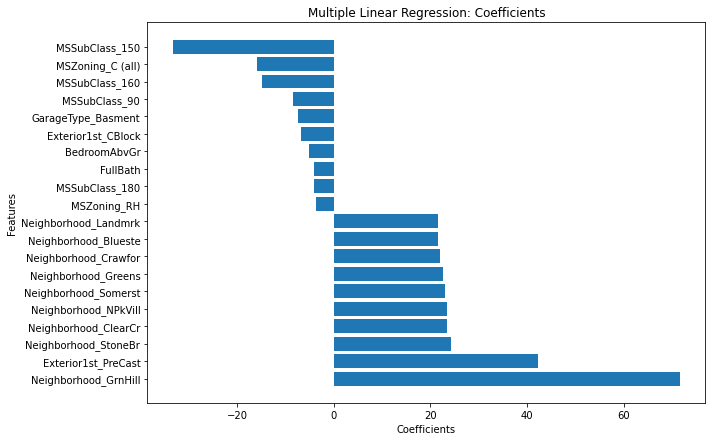

In [49]:
mlm_coefs_strong
fig = plt.figure(figsize =(10, 7))
plt.barh(np.arange(len(mlm_coefs_strong['Features'])), mlm_coefs_strong['Coefficients'])
plt.yticks(np.arange(len(mlm_coefs_strong['Features'])), mlm_coefs_strong['Features'])
plt.xlabel('Coefficients')
plt.ylabel('Features')
plt.title('Multiple Linear Regression: Coefficients')
plt.show()

In [50]:
mlm_changeable_cols = [feat for feat in mlm_coefs['Features'] if feat not in unchangeable_feats]
mlm_coefs = mlm_coefs[mlm_coefs['Features'].isin(mlm_changeable_cols)]
mlm_coefs_df = mlm_coefs[list(map(any, zip(mlm_coefs['Coefficients']>1, mlm_coefs['Coefficients']<-1)))]
mlm_coefs_df

,Features,Coefficients
98,Functional,5.007857
91,OverallCond,4.878499
97,KitchenQual,3.017940
94,BsmtExposure,2.877866
93,BsmtCond,2.750150
96,HeatingQC,1.525403
83,BsmtFullBath,1.455928
85,HalfBath,-2.983011
87,KitchenAbvGr,-3.322405
84,FullBath,-4.176211


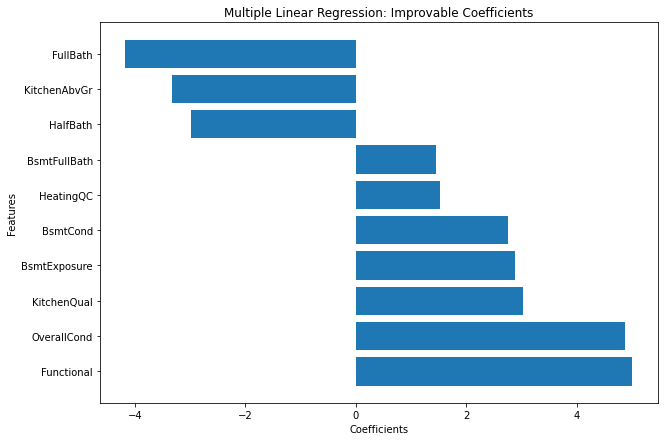

In [51]:
mlm_coefs_df
fig = plt.figure(figsize =(10, 7))
plt.barh(np.arange(len(mlm_coefs_df['Features'])), mlm_coefs_df['Coefficients'])
plt.yticks(np.arange(len(mlm_coefs_df['Features'])), mlm_coefs_df['Features'])
plt.xlabel('Coefficients')
plt.ylabel('Features')
plt.title('Multiple Linear Regression: Improvable Coefficients')
plt.show()

## Ridge Model

In [52]:
from sklearn.linear_model import Ridge

In [53]:
cv = KFold(n_splits=3, shuffle=True, random_state=0)

grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
ridgemodel = Ridge()

In [54]:
search = GridSearchCV(ridgemodel, grid, scoring=adj_r2_scorer, cv=cv, n_jobs=-1)
results = search.fit(x_train, y_train)

In [55]:
# summarize
print('Adj R Squared: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

Adj R Squared: 0.686
Config: {'alpha': 10.0}


In [56]:
grid['alpha'] = np.arange(0, 20, 1)
search = GridSearchCV(ridgemodel, grid, scoring=adj_r2_scorer, cv=cv, n_jobs=-1)
results = search.fit(x_train, y_train)

In [57]:
# summarize
print('Adj R Squared: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

Adj R Squared: 0.687
Config: {'alpha': 4}


In [58]:
grid['alpha'] = np.arange(4, 6, 0.1)
search = GridSearchCV(ridgemodel, grid, scoring=adj_r2_scorer, cv=cv, n_jobs=-1)
results = search.fit(x_train, y_train)

In [59]:
# summarize
print('Adj R Squared: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

Adj R Squared: 0.687
Config: {'alpha': 4.399999999999999}


In [60]:
ridgemodel = Ridge(alpha=results.best_params_['alpha'])
ridgemodel.fit(x_train, y_train)

print(ridgemodel.score(x_train, y_train))
print(f'Train Score (Adj R Sq): {1 - (1-ridgemodel.score(x_train, y_train))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)}')
print(ridgemodel.score(x_test, y_test))
print(f'Test Score (Adj R Sq): {1 - (1-ridgemodel.score(x_test, y_test))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)}')

0.7848336882723773
Train Score (Adj R Sq): 0.7330053066153588
0.776223861316005
Test Score (Adj R Sq): 0.7223215797351886


In [61]:
ridge_coef_list = [lis_ for list_ in ridgemodel.coef_ for lis_ in list_]
ridge_coefs = pd.DataFrame({'Features':x_test.columns,
              'Coefficients':ridge_coef_list}).sort_values(by='Coefficients', ascending=False)
ridge_coefs_strong = pd.concat((ridge_coefs.head(10), ridge_coefs.tail(10)), axis=0)
ridge_coefs_strong

,Features,Coefficients
60,Neighborhood_GrnHill,17.829569
21,SaleCondition_Partial,13.690973
74,Neighborhood_Somerst,9.908527
7,Exterior1st_BrkFace,9.634366
56,Neighborhood_Crawfor,9.400184
75,Neighborhood_StoneBr,9.286262
49,MSSubClass_85,8.356221
54,Neighborhood_ClearCr,7.609840
69,Neighborhood_NridgHt,7.528064
66,Neighborhood_NPkVill,7.521473


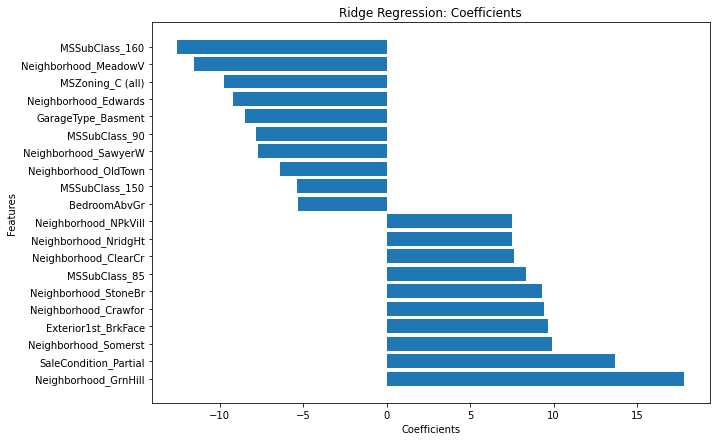

In [62]:
ridge_coefs_strong
fig = plt.figure(figsize =(10, 7))
plt.barh(np.arange(len(ridge_coefs_strong['Features'])), ridge_coefs_strong['Coefficients'])
plt.yticks(np.arange(len(ridge_coefs_strong['Features'])), ridge_coefs_strong['Features'])
plt.xlabel('Coefficients')
plt.ylabel('Features')
plt.title('Ridge Regression: Coefficients')
plt.show()

In [63]:
ridge_changeable_cols = [feat for feat in ridge_coefs['Features'] if feat not in unchangeable_feats]
ridge_coefs = ridge_coefs[ridge_coefs['Features'].isin(ridge_changeable_cols)]
ridge_coefs_df = ridge_coefs[list(map(any, zip(ridge_coefs['Coefficients']>1, ridge_coefs['Coefficients']<-1)))]
ridge_coefs_df

,Features,Coefficients
91,OverallCond,5.086426
98,Functional,5.008599
97,KitchenQual,2.942586
94,BsmtExposure,2.912713
93,BsmtCond,2.521129
83,BsmtFullBath,1.695935
96,HeatingQC,1.594388
85,HalfBath,-2.896238
84,FullBath,-3.794846
87,KitchenAbvGr,-5.261450


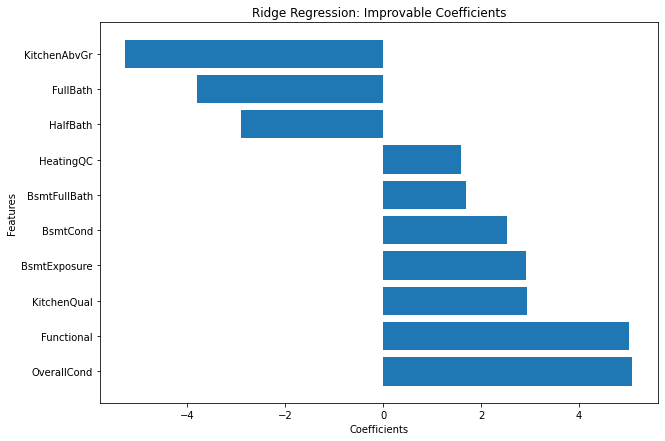

In [64]:
ridge_coefs_df
fig = plt.figure(figsize =(10, 7))
plt.barh(np.arange(len(ridge_coefs_df['Features'])), ridge_coefs_df['Coefficients'])
plt.yticks(np.arange(len(ridge_coefs_df['Features'])), ridge_coefs_df['Features'])
plt.xlabel('Coefficients')
plt.ylabel('Features')
plt.title('Ridge Regression: Improvable Coefficients')
plt.show()

## Lasso Model

In [65]:
from sklearn.linear_model import Lasso

In [66]:
lassomodel = Lasso(alpha=1.0)

lassomodel.fit(x_train, y_train)

Lasso()

In [67]:
print(lassomodel.score(x_train, y_train))
print(lassomodel.score(x_test, y_test))
1 - (1-lassomodel.score(x_test, y_test))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)

0.6855817057770035
0.6999317084224097


0.62765248490372

In [68]:
cv = KFold(n_splits=3, shuffle=True, random_state=0)

grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
lassomodel = Lasso()

In [69]:
search = GridSearchCV(lassomodel, grid, scoring=adj_r2_scorer, cv=cv, n_jobs=-1)
results = search.fit(x_train, y_train)

In [70]:
# summarize
print('Adj R Squared: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

Adj R Squared: 0.679
Config: {'alpha': 0.01}


In [71]:
grid['alpha'] = np.arange(0, 0.05, 0.01)
search = GridSearchCV(ridgemodel, grid, scoring=adj_r2_scorer, cv=cv, n_jobs=-1)
results = search.fit(x_train, y_train)

In [72]:
# summarize
print('Adj R Squared: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

Adj R Squared: 0.673
Config: {'alpha': 0.04}


In [73]:
lassomodel = Lasso(alpha=results.best_params_['alpha'])
lassomodel.fit(x_train, y_train)

print(lassomodel.score(x_train, y_train))
print(f'Train Score (Adj R Sq): {1 - (1-lassomodel.score(x_train, y_train))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)}')
print(lassomodel.score(x_test, y_test))
print(f'Test Score (Adj R Sq): {1 - (1-lassomodel.score(x_test, y_test))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)}')

0.7792873438015393
Train Score (Adj R Sq): 0.7261229813595743
0.7760708201291946
Test Score (Adj R Sq): 0.7221316746128692


In [74]:
lassomodel.coef_
lasso_coefs = pd.DataFrame({'Features':x_test.columns,
              'Coefficients':lassomodel.coef_}).sort_values(by='Coefficients', ascending=False)
lasso_coefs_strong = pd.concat((lasso_coefs.head(10), lasso_coefs.tail(10)), axis=0)
lasso_coefs_strong

,Features,Coefficients
60,Neighborhood_GrnHill,26.967714
21,SaleCondition_Partial,12.593327
56,Neighborhood_Crawfor,9.769281
74,Neighborhood_Somerst,9.632276
7,Exterior1st_BrkFace,8.162542
75,Neighborhood_StoneBr,6.994140
69,Neighborhood_NridgHt,6.319483
54,Neighborhood_ClearCr,5.789324
3,MSZoning_RL,5.544724
29,Condition1_Norm,5.388838


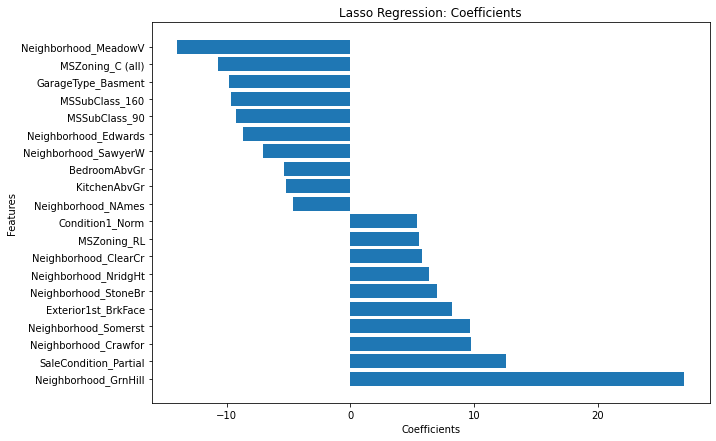

In [75]:
lasso_coefs_strong
fig = plt.figure(figsize =(10, 7))
plt.barh(np.arange(len(lasso_coefs_strong['Features'])), lasso_coefs_strong['Coefficients'])
plt.yticks(np.arange(len(lasso_coefs_strong['Features'])), lasso_coefs_strong['Features'])
plt.xlabel('Coefficients')
plt.ylabel('Features')
plt.title('Lasso Regression: Coefficients')
plt.show()

In [76]:
lasso_changeable_cols = [feat for feat in lasso_coefs['Features'] if feat not in unchangeable_feats]
lasso_coefs = lasso_coefs[lasso_coefs['Features'].isin(lasso_changeable_cols)]
lasso_coefs_df = lasso_coefs[list(map(any, zip(lasso_coefs['Coefficients']>1, lasso_coefs['Coefficients']<-1)))]
lasso_coefs_df

,Features,Coefficients
91,OverallCond,5.173242
98,Functional,4.948856
94,BsmtExposure,3.026088
97,KitchenQual,2.832652
93,BsmtCond,2.580260
83,BsmtFullBath,1.545242
96,HeatingQC,1.530041
85,HalfBath,-2.456795
84,FullBath,-3.265217
87,KitchenAbvGr,-5.191633


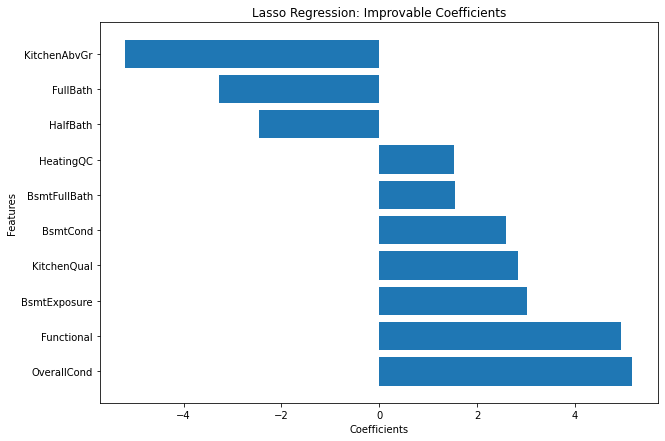

In [77]:
lasso_coefs_df
fig = plt.figure(figsize =(10, 7))
plt.barh(np.arange(len(lasso_coefs_df['Features'])), lasso_coefs_df['Coefficients'])
plt.yticks(np.arange(len(lasso_coefs_df['Features'])), lasso_coefs_df['Features'])
plt.xlabel('Coefficients')
plt.ylabel('Features')
plt.title('Lasso Regression: Improvable Coefficients')
plt.show()

## Elastic Net Model

In [78]:
from sklearn.linear_model import ElasticNet

In [79]:
enmodel = ElasticNet(alpha=1.0, l1_ratio=0.5)

enmodel.fit(x_train, y_train)

ElasticNet()

In [80]:
print(enmodel.score(x_train, y_train))
print(enmodel.score(x_test, y_test))
1 - (1-enmodel.score(x_test, y_test))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)

0.6685444424985554
0.6798639030825602


0.6027508286425929

#### Tuning Hyper Paramaters: Cross Validation and Grid Search

In [81]:
cv = KFold(n_splits=3, shuffle=True, random_state=0)

grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = np.arange(0, 1, 0.01)
enmodel = ElasticNet()

In [82]:
search = GridSearchCV(enmodel, grid, scoring=adj_r2_scorer, cv=cv, n_jobs=-1)
results = search.fit(x_train, y_train)

In [83]:
# summarize
print('Adj R Squared: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

Adj R Squared: 0.687
Config: {'alpha': 0.01, 'l1_ratio': 0.59}


In [84]:
grid['alpha'] = [0, 0.005, 0.010, 0.015, 0.020]
grid['l1_ratio'] = np.arange(0, 1, 0.1)
search = GridSearchCV(enmodel, grid, scoring=adj_r2_scorer, cv=cv, n_jobs=-1)
results = search.fit(x_train, y_train)

In [85]:
# summarize
print('Adj R Squared: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

Adj R Squared: 0.687
Config: {'alpha': 0.005, 'l1_ratio': 0.1}


In [86]:
grid['alpha'] = np.arange(0, 0.010, 0.001)
grid['l1_ratio'] = np.arange(0, 1, 0.1)
search = GridSearchCV(enmodel, grid, scoring=adj_r2_scorer, cv=cv, n_jobs=-1)
results = search.fit(x_train, y_train)

C:\Users\Nixon\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 144437.57911412552, tolerance: 126.5972113133975
  model = cd_fast.enet_coordinate_descent(


In [87]:
# summarize
print('Adj R Squared: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

Adj R Squared: 0.687
Config: {'alpha': 0.004, 'l1_ratio': 0.0}


In [88]:
enmodel = ElasticNet(alpha=results.best_params_['alpha'], l1_ratio=results.best_params_['l1_ratio'])

enmodel.fit(x_train, y_train)

print(enmodel.score(x_train, y_train))
print(f'Train Score (Adj R Sq): {1 - (1-enmodel.score(x_train, y_train))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)}')
print(enmodel.score(x_test, y_test))
print(f'Test Score (Adj R Sq): {1 - (1-enmodel.score(x_test, y_test))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)}')

C:\Users\Nixon\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 144437.57911412552, tolerance: 126.5972113133975
  model = cd_fast.enet_coordinate_descent(


0.782854134611879
Train Score (Adj R Sq): 0.7305489261607259
0.776460740191213
Test Score (Adj R Sq): 0.7226155170255928


In [89]:
enmodel.coef_
en_coefs = pd.DataFrame({'Features':x_test.columns,
              'Coefficients':enmodel.coef_}).sort_values(by='Coefficients', ascending=False)
en_coefs_strong = pd.concat((en_coefs.head(10), en_coefs.tail(10)), axis=0)
en_coefs_strong

,Features,Coefficients
60,Neighborhood_GrnHill,13.997486
21,SaleCondition_Partial,12.580293
74,Neighborhood_Somerst,9.199200
56,Neighborhood_Crawfor,9.162263
7,Exterior1st_BrkFace,9.140535
75,Neighborhood_StoneBr,8.352878
49,MSSubClass_85,7.567178
54,Neighborhood_ClearCr,6.921361
69,Neighborhood_NridgHt,6.812477
3,MSZoning_RL,6.642195


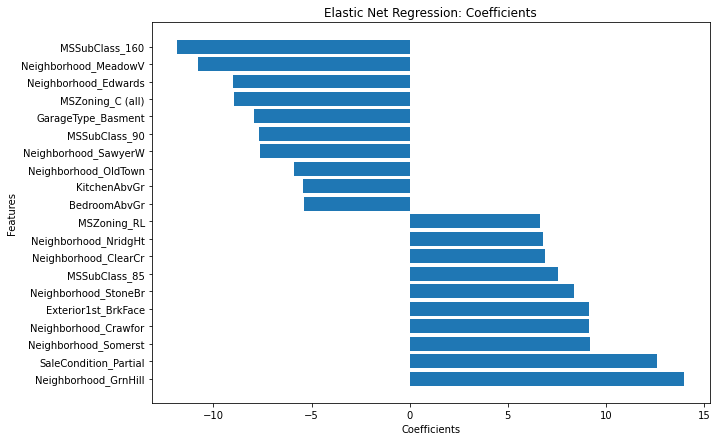

In [90]:
en_coefs_strong
fig = plt.figure(figsize =(10, 7))
plt.barh(np.arange(len(en_coefs_strong['Features'])), en_coefs_strong['Coefficients'])
plt.yticks(np.arange(len(en_coefs_strong['Features'])), en_coefs_strong['Features'])
plt.xlabel('Coefficients')
plt.ylabel('Features')
plt.title('Elastic Net Regression: Coefficients')
plt.show()

In [91]:
en_changeable_cols = [feat for feat in en_coefs['Features'] if feat not in unchangeable_feats]
en_coefs = en_coefs[en_coefs['Features'].isin(en_changeable_cols)]
en_coefs_df = en_coefs[list(map(any, zip(en_coefs['Coefficients']>1, en_coefs['Coefficients']<-1)))]
en_coefs_df

,Features,Coefficients
91,OverallCond,5.104514
98,Functional,5.006743
97,KitchenQual,2.955367
94,BsmtExposure,2.913641
93,BsmtCond,2.486850
83,BsmtFullBath,1.706754
96,HeatingQC,1.607676
85,HalfBath,-2.858372
84,FullBath,-3.669437
87,KitchenAbvGr,-5.439733


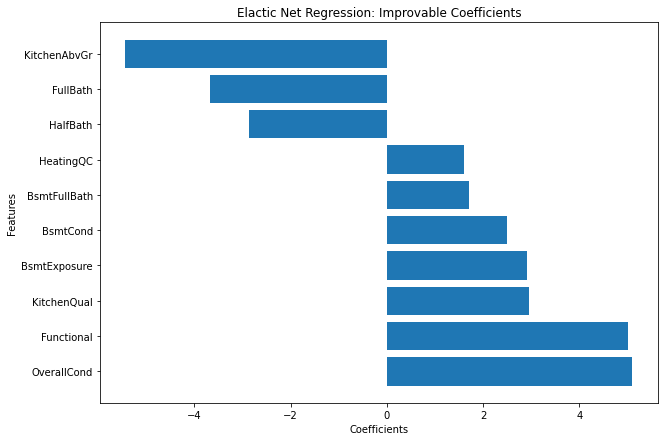

In [92]:
en_coefs_df
fig = plt.figure(figsize =(10, 7))
plt.barh(np.arange(len(en_coefs_df['Features'])), en_coefs_df['Coefficients'])
plt.yticks(np.arange(len(en_coefs_df['Features'])), en_coefs_df['Features'])
plt.xlabel('Coefficients')
plt.ylabel('Features')
plt.title('Elactic Net Regression: Improvable Coefficients')
plt.show()

### Random Forest Regression

In [93]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [95]:
X_80_rf = pd.concat((pd.get_dummies(X_80[cat_colnames]), X_80[ord_colnames+num_colnames]),axis=1)

In [96]:
# Train Test Split
x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(np.array(X_80_rf), np.array(y_80['SalePricePerGLA']), random_state=1, test_size=0.25)

In [97]:
print(x_train_rf.shape)
# Choose max_depth based on num of obs
print(2**10)
# 1024, not 6000 yet
2**11
#8192, should not pass 11 steps

(1531, 234)
1024


2048

In [98]:
rf = RandomForestRegressor(n_estimators = 500, random_state = 0)
# Train the model on training data
rf.fit(x_train_rf, y_train_rf)

print(rf.score(x_train_rf, y_train_rf))
rf.score(x_test_rf, y_test_rf)

0.970770927571022


0.7984409206375296

In [99]:
grid_params = {
    "rf__n_estimators" : [100, 500, 1000],
    "rf__max_depth": [3,6,9,11]
}

cv = KFold(n_splits=3, shuffle=True, random_state=1)

pipeline = Pipeline([
    ("ss", StandardScaler()), 
#     ("pca", PCA(n_components=0.85)), 
    ("rf", RandomForestRegressor())
])
rf = RandomForestRegressor()
gs = GridSearchCV(pipeline, grid_params, cv=cv, return_train_score=True)

In [100]:
import time

start = time.time()

gs.fit(x_train_rf, y_train_rf)

print(time.time() - start)

253.55744457244873


In [101]:
print(gs.best_params_)

print(f'Train Score: {gs.score(x_train_rf, y_train_rf)}')
print(f'Test Score: {gs.score(x_test_rf, y_test_rf)}')

{'rf__max_depth': 11, 'rf__n_estimators': 1000}
Train Score: 0.9506024446113496
Test Score: 0.7951632155387683


In [102]:
rf.set_params(n_estimators=gs.best_params_['rf__n_estimators'], max_depth=gs.best_params_['rf__max_depth'], random_state=1)
rf.fit(x_train_rf, y_train_rf)

print(f'Train Score: {rf.score(x_train_rf, y_train_rf)}')
print(f'Test Score: {rf.score(x_test_rf, y_test_rf)}')

Train Score: 0.9508851298106187
Test Score: 0.7958984391962626


In [103]:
pipeline.set_params(rf__n_estimators=gs.best_params_['rf__n_estimators'], rf__max_depth=gs.best_params_['rf__max_depth'])
pipeline.fit(x_train_rf, y_train_rf)

print(f'Train Score: {pipeline.score(x_train_rf, y_train_rf)}')
print(f'Test Score: {pipeline.score(x_test_rf, y_test_rf)}')

Train Score: 0.9504352418023928
Test Score: 0.7956528252242906


In [104]:
rf.feature_importances_
rf_feat_importance = pd.DataFrame({'Features':X_80_rf.columns,
              'Feature_Importances':rf.feature_importances_}).sort_values(by='Feature_Importances', ascending=False)
rf_feat_importance.head(20)

,Features,Feature_Importances
212,2ndFlrSF,0.218859
204,YearBuilt,0.158031
184,OverallQual,0.094818
191,BsmtFinType1,0.089168
211,1stFlrSF,0.048881
185,OverallCond,0.046845
207,BsmtFinSF1,0.044641
205,YearRemodAdd,0.023310
5,MSSubClass_20,0.020034
222,GarageYrBlt,0.015987


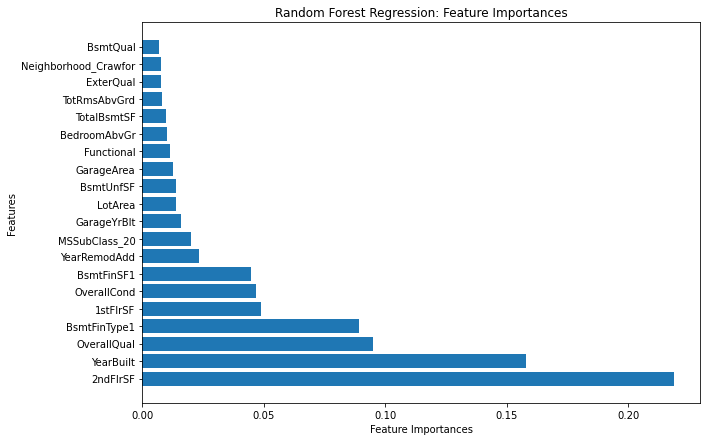

In [105]:
rf_feat_importance.head(20)
fig = plt.figure(figsize =(10, 7))
plt.barh(np.arange(len(rf_feat_importance.head(20)['Features'])), rf_feat_importance.head(20)['Feature_Importances'])
plt.yticks(np.arange(len(rf_feat_importance.head(20)['Features'])), rf_feat_importance.head(20)['Features'])
plt.xlabel('Feature Importances')
plt.ylabel('Features')
plt.title('Random Forest Regression: Feature Importances')
plt.show()

In [106]:
unchangeable_feats_rf = unchangeable_feats + ['1stFlrSF'] + ['GarageYrBlt'] + ['LotArea'] + ['TotalBsmtSF'] + ['MoSold'] + ['YrSold']

In [107]:
rf_changeable_cols = [feat for feat in X_80_rf.columns if feat not in unchangeable_feats_rf]
rf_feat_importance = rf_feat_importance[rf_feat_importance['Features'].isin(rf_changeable_cols)]
rf_feat_importance.head(20)

,Features,Feature_Importances
184,OverallQual,0.094818
191,BsmtFinType1,0.089168
185,OverallCond,0.046845
207,BsmtFinSF1,0.044641
205,YearRemodAdd,0.023310
209,BsmtUnfSF,0.013692
195,Functional,0.011513
220,TotRmsAbvGrd,0.007963
188,BsmtQual,0.006933
219,KitchenAbvGr,0.006155


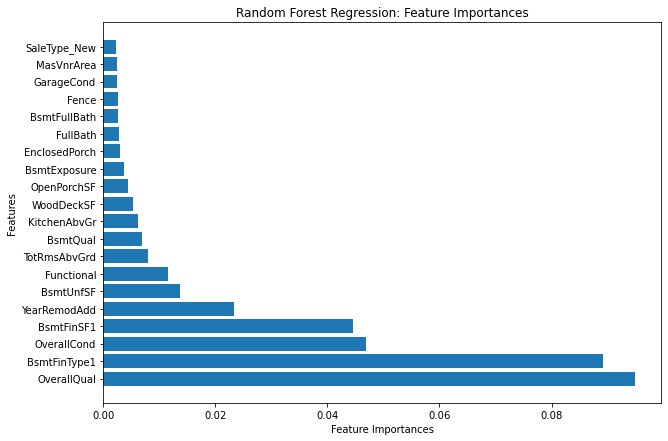

In [108]:
rf_feat_importance.head(20)
fig = plt.figure(figsize =(10, 7))
plt.barh(np.arange(len(rf_feat_importance.head(20)['Features'])), rf_feat_importance.head(20)['Feature_Importances'])
plt.yticks(np.arange(len(rf_feat_importance.head(20)['Features'])), rf_feat_importance.head(20)['Features'])
plt.xlabel('Feature Importances')
plt.ylabel('Features')
plt.title('Random Forest Regression: Feature Importances')
plt.show()

### Undervalued Homes

In [109]:
print(gs.best_params_)
rf.set_params(n_estimators=gs.best_params_['rf__n_estimators'], max_depth=gs.best_params_['rf__max_depth'])
rf.fit(x_train_rf, y_train_rf)

print(f'Train Score: {rf.score(x_train_rf, y_train_rf)}')
print(f'Test Score: {rf.score(x_test_rf, y_test_rf)}')

{'rf__max_depth': 11, 'rf__n_estimators': 1000}
Train Score: 0.9508851298106187
Test Score: 0.7958984391962626


In [110]:
X_rf_bottom_80 = pd.concat((pd.concat((pd.get_dummies(ames_housing_X[cat_colnames]), 
                                       pd.concat((ames_housing_X[ord_colnames], ames_housing_X[num_colnames]), axis=1)), axis=1),
                            data[['Neighborhood', 'GrLivArea', 'PID', 'SalePrice']]), axis=1).iloc[bottom_eighty]
X_rf_bottom_80

,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,Neighborhood,GrLivArea,PID,SalePrice
917,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,2007,BrkSide,334,534450090,39300
854,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,3,2008,OldTown,407,902205070,46500
1550,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,2009,SWISU,438,909175080,60000
644,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,10,2006,IDOTRR,480,911175430,35311
37,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,6,2006,OldTown,492,902206020,61500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,5,2006,BrkSide,1827,903206160,202500
433,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,2007,IDOTRR,1828,910201180,150909
2517,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,6,2009,CollgCr,1828,907275140,279500
1474,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,2010,CollgCr,1829,907262050,237000


In [111]:
# rf.predict(X_rf_bottom_80[X_80_rf.columns])


In [112]:
# X_rf_bottom_80['PredictedSP'] = np.round(rf.predict(X_rf_bottom_80[X_80_rf.columns]) * X_rf_bottom_80['GrLivArea'], 2)

In [113]:
# Df of X columns before dummification and label encoding
# Includes 'GrLivArea'
uv_prep_data = data.iloc[bottom_eighty]

In [114]:
# Get mean and std by neighborhood
mean_std_neighborhood = uv_prep_data.groupby('Neighborhood').agg({
    'SalePricePerGLA':['mean', 'std']}).rename(columns={'mean':'meanSPperGLA', 'std':'stdSPperGLA'})['SalePricePerGLA']
mean_std_neighborhood

,meanSPperGLA,stdSPperGLA
Neighborhood,,
Blmngtn,138.681141,14.222758
Blueste,126.218703,34.476442
BrDale,96.563402,9.092847
BrkSide,104.966414,19.019345
ClearCr,138.137431,35.811145
CollgCr,140.337835,19.370182
Crawfor,123.339165,25.680766
Edwards,105.425513,27.695400
Gilbert,121.215507,16.980761


In [115]:
X_rf_bottom_80 = X_rf_bottom_80.merge(mean_std_neighborhood, how='left', left_on='Neighborhood', right_on=mean_std_neighborhood.index)

X_rf_bottom_80

,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,...,PoolArea,MiscVal,MoSold,YrSold,Neighborhood,GrLivArea,PID,SalePrice,meanSPperGLA,stdSPperGLA
0,0,0,0,0,0,1,0,0,0,0,...,0,0,1,2007,BrkSide,334,534450090,39300,104.966414,19.019345
1,0,0,0,0,0,1,0,0,0,0,...,0,0,3,2008,OldTown,407,902205070,46500,97.892575,21.319455
2,0,0,0,0,0,0,1,0,0,0,...,0,0,1,2009,SWISU,438,909175080,60000,95.929130,23.465759
3,0,0,0,0,0,1,0,0,0,0,...,0,0,10,2006,IDOTRR,480,911175430,35311,94.768499,24.924955
4,0,0,0,0,0,0,1,0,0,0,...,0,0,6,2006,OldTown,492,902206020,61500,97.892575,21.319455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2037,0,0,0,0,0,0,0,0,0,0,...,0,0,5,2006,BrkSide,1827,903206160,202500,104.966414,19.019345
2038,0,0,0,0,0,0,0,0,0,0,...,0,0,3,2007,IDOTRR,1828,910201180,150909,94.768499,24.924955
2039,0,0,0,0,0,1,0,0,0,0,...,0,0,6,2009,CollgCr,1828,907275140,279500,140.337835,19.370182
2040,0,0,0,0,0,0,0,0,0,0,...,0,0,1,2010,CollgCr,1829,907262050,237000,140.337835,19.370182


In [116]:
# Get meanSP and stdSP by multipling by GLA & get the Undervalued Home Threshold
X_rf_bottom_80['meanSP'] = X_rf_bottom_80['meanSPperGLA'] * X_rf_bottom_80['GrLivArea']
X_rf_bottom_80['stdSP'] = X_rf_bottom_80['stdSPperGLA'] * X_rf_bottom_80['GrLivArea']
# uv_prep_data['stdSP'] can be replace with an amount below the mean SalePrice if you are a DOMAIN EXPERT
X_rf_bottom_80['UV_Treshold'] = X_rf_bottom_80['meanSP']-X_rf_bottom_80['stdSP']


In [117]:
undervalued_X_80_rf = X_rf_bottom_80[X_rf_bottom_80['SalePrice']<=X_rf_bottom_80['UV_Treshold']]

In [118]:
undervalued_X_80_rf.shape[0]

308

In [119]:
# X_80_rf_copy[X_80_rf_copy['PredictedSP']<=X_80_rf_copy['UV_Treshold']]

In [120]:
rf_feat_importance.head(15)['Features']

184      OverallQual
191     BsmtFinType1
185      OverallCond
207       BsmtFinSF1
205     YearRemodAdd
209        BsmtUnfSF
195       Functional
220     TotRmsAbvGrd
188         BsmtQual
219     KitchenAbvGr
225       WoodDeckSF
226      OpenPorchSF
190     BsmtExposure
227    EnclosedPorch
216         FullBath
Name: Features, dtype: object

In [121]:
rf_improvable_feat = ['OverallQual', 'BsmtFinType1', 'OverallCond', 'BsmtFinSF1', 'YearRemodAdd', 
'BsmtUnfSF', 'Functional', 'TotRmsAbvGrd', 'BsmtQual', 'KitchenAbvGr', 
'WoodDeckSF', 'OpenPorchSF', 'BsmtExposure', 'EnclosedPorch', 'KitchenQual']

xgboost_improvable_feat = ['BsmtFinSF1', 'YearRemodAdd', 'OpenPorchSF', 'OverallQual',
       'WoodDeckSF', 'EnclosedPorch', 'OverallCond', 'MasVnrArea',
       'BsmtFinType1', 'HeatingQC', 'BsmtExposure', 'Fireplaces', 'Functional',
       'BsmtFinType2', 'Fence']

svr_improvable_feat = ['OverallQual', 'OverallCond', 'BsmtFinSF1', 'BsmtExposure', 'MasVnrType_None', 
 'MasVnrType_BrkFace', 'KitchenQual', 'MiscFeature_NoneListed', 'BsmtQual', 'BsmtFullBath', 
 'MiscFeature_Shed', 'MasVnrArea', 'Functional', 'FireplaceQu', 'KitchenAbvGr', 
 'BsmtUnfSF', 'LowQualFinSF']

common_improvable_feat = [feat for feat in [feat for feat in rf_improvable_feat if feat in xgboost_improvable_feat] if feat in svr_improvable_feat]
common_improvable_feat

['OverallQual', 'OverallCond', 'BsmtFinSF1', 'Functional', 'BsmtExposure']

In [122]:
['OverallQual', # set at 9
 'OverallCond', # set at 9
 'BsmtFinSF1',  # add 1/2 of BsmtUnfSF
 'BsmtUnfSF',   # divide by 2
 'Functional',  # set at 6
 'BsmtExposure']# set at 3

['OverallQual',
 'OverallCond',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'Functional',
 'BsmtExposure']

In [123]:
undervalued_X_80_rf[common_improvable_feat]

,OverallQual,OverallCond,BsmtFinSF1,Functional,BsmtExposure
5,2,3,0.0,7,1
11,2,4,0.0,7,0
21,2,2,0.0,5,0
29,4,4,0.0,7,1
35,3,3,0.0,7,2
...,...,...,...,...,...
2017,6,5,0.0,7,1
2021,7,5,0.0,7,1
2023,5,5,540.0,7,1
2034,6,5,0.0,7,3


In [124]:
undervalued_X_80_rf[['OverallQual']] = 9
undervalued_X_80_rf[['OverallCond']] = 9
undervalued_X_80_rf[['BsmtFinSF1']] = undervalued_X_80_rf['BsmtFinSF1'] + (undervalued_X_80_rf['BsmtUnfSF']/2)
undervalued_X_80_rf[['BsmtUnfSF']] = undervalued_X_80_rf['BsmtUnfSF']/2
undervalued_X_80_rf[['Functional']] = 6
undervalued_X_80_rf[['BsmtExposure']] = 3


<ipython-input-124-bcc77855aa76>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  undervalued_X_80_rf[['OverallQual']] = 9
C:\Users\Nixon\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-124-bcc77855aa76>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

In [125]:
undervalued_X_80_rf[common_improvable_feat]

,OverallQual,OverallCond,BsmtFinSF1,Functional,BsmtExposure
5,9,9,249.0,6,3
11,9,9,0.0,6,3
21,9,9,0.0,6,3
29,9,9,346.5,6,3
35,9,9,357.5,6,3
...,...,...,...,...,...
2017,9,9,390.0,6,3
2021,9,9,476.0,6,3
2023,9,9,702.0,6,3
2034,9,9,456.0,6,3


In [126]:
undervalued_X_80_rf[X_80_rf.columns]

,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
5,0,0,0,0,0,0,1,0,0,0,...,216.0,0,0,100,0,0,0,0,2,2006
11,0,0,0,0,0,0,1,0,0,0,...,308.0,0,0,25,0,0,0,0,10,2009
21,0,0,0,0,0,1,0,0,0,0,...,0.0,0,0,100,0,0,0,0,6,2009
29,0,0,0,0,0,0,1,0,0,0,...,0.0,0,20,0,0,0,0,0,3,2006
35,0,0,0,0,0,0,1,0,0,0,...,660.0,0,0,75,0,112,0,0,8,2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017,0,0,0,0,0,0,0,0,0,0,...,483.0,0,55,0,0,0,0,0,3,2009
2021,0,0,0,0,0,0,0,0,0,0,...,469.0,144,112,0,0,0,0,0,4,2008
2023,0,0,0,0,0,0,0,0,0,0,...,264.0,0,168,0,0,0,0,0,7,2007
2034,0,0,0,0,0,0,0,0,0,0,...,0.0,128,0,0,0,0,0,0,4,2010


In [127]:
undervalued_X_80_rf['PotentialProfit'] = rf.predict(undervalued_X_80_rf[X_80_rf.columns])
undervalued_X_80_rf['PotentialProfit']

<ipython-input-127-da08bbbd8d44>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  undervalued_X_80_rf['PotentialProfit'] = rf.predict(undervalued_X_80_rf[X_80_rf.columns])


5       126.766746
11      122.643439
21      120.802063
29      126.559021
35      133.914465
           ...    
2017     93.460642
2021    118.980295
2023    109.725541
2034     93.274595
2035    112.137934
Name: PotentialProfit, Length: 308, dtype: float64

In [128]:
underval_PID_rf = list(undervalued_X_80_rf.sort_values(by='PotentialProfit', ascending=False).head(50)['PID'])
underval_PID_rf

[528228295,
 916402115,
 533252020,
 532479120,
 907405030,
 533251130,
 532477030,
 533251120,
 533253160,
 528228435,
 528228450,
 907200230,
 907202130,
 528228290,
 533352150,
 528188020,
 528188040,
 527405130,
 916402015,
 923400150,
 923229110,
 905103060,
 914452060,
 907203090,
 527182020,
 905200160,
 535452120,
 534175010,
 534250010,
 907202240,
 531478010,
 534252060,
 923205025,
 902477120,
 535377070,
 535325280,
 532378120,
 906380050,
 528290140,
 533135020,
 533236060,
 533236050,
 907414080,
 907412080,
 907180040,
 907131120,
 527225035,
 903204095,
 531477020,
 907185050]

In [129]:
underval_PID_xgb = [908275110,
 534252060,
 535126100,
 923125030,
 528228295,
 533352150,
 535354260,
 902305090,
 905226110,
 905200290,
 535475020,
 911102170,
 923202060,
 535452120,
 534427010,
 532479120,
 905103060,
 535325320,
 916402115,
 902207130,
 905450020,
 535327230,
 916402015,
 923205025,
 902301060,
 534451150,
 535150070,
 526302120,
 905478030,
 905226050,
 909256060,
 909250030,
 907202240,
 902109120,
 535175030,
 902325160,
 532351090,
 535101110,
 908225370,
 907405030,
 902402260,
 535353190,
 528228450,
 535379060,
 905200160,
 904302260,
 535101150,
 534250010,
 528188150,
 532479020]

underval_PID_lasso = [923125030,
 902305090,
 535327230,
 535457040,
 905101310,
 905402060,
 909250030,
 534451150,
 905200290,
 908225370,
 535150070,
 909452102,
 535354200,
 902402260,
 534252060,
 905229040,
 904101170,
 905226110,
 534225110,
 905478030,
 535101120,
 535325320,
 923202060,
 532376090,
 533352150,
 534225120,
 902109120,
 903481100,
 905378040,
 908275040,
 535126100,
 908201120,
 902406090,
 534250010,
 902125080,
 535456050,
 902301060,
 527401160,
 906200230,
 909256060,
 923226150,
 908188130,
 909276210,
 923204140,
 535152010,
 914476450,
 535101110,
 908275290,
 903206070,
 905377020]

underval_PID_svr = [911102170,
 908102130,
 903484080,
 902207130,
 902103090,
 909250210,
 905200290,
 914476020,
 534427010,
 535456050,
 923202060,
 905480210,
 902109130,
 535150070,
 905450020,
 905480160,
 909101140,
 923125030,
 902325160,
 535457040,
 904100170,
 902427040,
 905478030,
 904351200,
 902305090,
 909250120,
 908204180,
 905101310,
 909250030,
 908204160,
 534225120,
 923204150,
 535379060,
 535180130,
 910205020,
 905480150,
 532376090,
 903458110,
 534479120,
 902134060,
 905226110,
 535354260,
 535126100,
 914452060,
 902402260,
 905480090,
 527451020,
 902109080,
 911102090,
 905351045]

common_underval_PID = [feat for feat in [feat for feat in underval_PID_rf if feat in underval_PID_xgb] if feat in underval_PID_lasso]
common_underval_PID

[533352150, 534250010, 534252060]

In [130]:
[feat for feat in underval_PID_xgb[0:18] if feat in underval_PID_svr[0:18]]

[923125030, 905200290, 911102170, 923202060, 534427010]